# 02805 - Social Graphs and Interactions -  Project Assignment B

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import PIL
import networkx as nx
import itertools
from fa2 import ForceAtlas2
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches

from networkx.algorithms import community
import community
import random

import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud


%matplotlib inline

# 1) Motivation

In this project we have worked with data concerning a scraped collection of cocktails/drinks and their ingredients. Although the data-set is not too big, it contains very specific information containing each drink made, especially when considering the sets of ingredients.
We thought it would be fun to analyze the interconnectedness of these drinks, by creating a network of drinks where each node corresponds to a drink, and drinks are connected when they share an ingredient. The number of shared ingredients between two drinks constitute the weight of the connection.
We hope that this sort of network, would provide a fun visualization for viewers, and perhaps even provide a better understanding of which drinks are more related to each other.

We will also look within this network for smaller 'communities' of similar drinks to provide an even more comprehensible overview.

Furthermore, we thought it might be interesting to see how both the instructions and ingredients differ within each drink category and glasstype. For this, several different wordclouds have been created.

# 2) Basic Stats

**Cocktail Data**

The dataset contains 546 rows of each 40 columns. Each row corresponds to a drink, with each column corresponding to features concerning that drink. The most interesting features herein are Category, Glass, and the different Ingredients-columns. The data has been retrieved from https://www.kaggle.com/ai-first/cocktail-ingredients.

In [2]:
# Import data
df = pd.read_csv('../all_drinks.csv', encoding = 'utf-8')

# Removes row "Unnamed"
cols = df.columns
cols = cols[1:]
data = np.array(df)[:,1:]
df = pd.DataFrame(np.array(df)[:,1:])
df.columns = cols

df.head()

strDrink         dateModified idDrink  \
0  '57 Chevy with a White License Plate  2016-07-18 22:49:04   14029   
1                        1-900-FUK-MEUP  2016-07-18 22:27:04   15395   
2                      110 in the shade  2016-02-03 14:51:57   15423   
3                151 Florida Bushwacker  2016-07-18 22:28:43   14588   
4                           155 Belmont  2016-10-05 12:36:28   15346   

  strAlcoholic           strCategory  \
0    Alcoholic              Cocktail   
1    Alcoholic                  Shot   
2    Alcoholic                  Beer   
3    Alcoholic  Milk / Float / Shake   
4    Alcoholic              Cocktail   

                                       strDrinkThumb             strGlass  \
0  http://www.thecocktaildb.com/images/media/drin...       Highball glass   
1  http://www.thecocktaildb.com/images/media/drin...  Old-fashioned glass   
2  http://www.thecocktaildb.com/images/media/drin...           Beer Glass   
3  http://www.thecocktaildb.com/images/media/drin...             Beer mug   
4  http://www.thecocktaildb.com/images/media/drin...     White wine glass   

  strIBA  strIngredient1 strIngredient10  ... strMeasure15 strMeasure2  \
0    NaN  Creme de Cacao             NaN  ...          NaN       1 oz    
1    NaN  Absolut Kurant             NaN  ...          NaN     1/4 oz    
2    NaN           Lager             NaN  ...          NaN     1.5 oz    
3    NaN      Malibu rum             NaN  ...          NaN     1/2 oz    
4    NaN        Dark rum             NaN  ...          NaN    2 shots    

       strMeasure3 strMeasure4 strMeasure5 strMeasure6 strMeasure7  \
0                                                                    
1          1/4 oz      1/4 oz      1/4 oz      1/4 oz      1/2 oz    
2                                                                    
3  1/2 oz Bacardi        1 oz        1 oz        3 oz        1 oz    
4          1 shot      1 shot                                        

  strMeasure8 strMeasure9 strVideo  
0         NaN         NaN      NaN  
1     1/4 oz                   NaN  
2         NaN         NaN      NaN  
3      1 cup                   NaN  
4                              NaN  

[5 rows x 40 columns]

In [3]:
print(df.shape)
cols

(546, 40)


Index(['strDrink', 'dateModified', 'idDrink', 'strAlcoholic', 'strCategory',
       'strDrinkThumb', 'strGlass', 'strIBA', 'strIngredient1',
       'strIngredient10', 'strIngredient11', 'strIngredient12',
       'strIngredient13', 'strIngredient14', 'strIngredient15',
       'strIngredient2', 'strIngredient3', 'strIngredient4', 'strIngredient5',
       'strIngredient6', 'strIngredient7', 'strIngredient8', 'strIngredient9',
       'strInstructions', 'strMeasure1', 'strMeasure10', 'strMeasure11',
       'strMeasure12', 'strMeasure13', 'strMeasure14', 'strMeasure15',
       'strMeasure2', 'strMeasure3', 'strMeasure4', 'strMeasure5',
       'strMeasure6', 'strMeasure7', 'strMeasure8', 'strMeasure9', 'strVideo'],
      dtype='object')

In [4]:
# Get Categories

categories = np.array(df['strCategory'])
unique_categories, counts = np.unique(categories, return_counts=True)
c = np.asarray((unique_categories, counts)).T
print(c)

[['Beer' 13]
 ['Cocktail' 64]
 ['Cocoa' 9]
 ['Coffee / Tea' 25]
 ['Homemade Liqueur' 12]
 ['Milk / Float / Shake' 17]
 ['Ordinary Drink' 275]
 ['Other/Unknown' 34]
 ['Punch / Party Drink' 37]
 ['Shot' 49]
 ['Soft Drink / Soda' 11]]


The dataset contains information about drinks from the above-seen categories. As can be seen the most frequent type of drink is "ordinary drink" - what this entails will be explored further down. 
The most common ingredients within each category will be displayed by generating WordClouds.

In [5]:
# Get Ingredients

ingredient_indices = cols[8:23]
ingredients = data[:,8:23]
# Concatenate
ingredients_all = np.concatenate(ingredients)
# Remove empty fields
ingredients_all = [i for i in ingredients_all if isinstance(i, str)]
unique_ingredients, counts = np.unique(ingredients_all, return_counts=True)
print(unique_ingredients[:20])

['151 proof rum' '7-Up' 'Absinthe' 'Absolut Citron' 'Absolut Kurant'
 'Absolut Peppar' 'Absolut Vodka' 'Advocaat' 'Agave Syrup' 'Agave syrup'
 'Ale' 'Allspice' 'Almond' 'Almond flavoring' 'Amaretto' 'Angelica root'
 'Angostura Bitters' 'Angostura bitters' 'Anis' 'Anise']


*Above is seen the first 20 unique ingredients contained within the data-set.*

# 3) Tools, Theory and Analysis

## The Network

In [6]:
dim = df.shape[0]

# Init graph
G = nx.Graph()
G.add_nodes_from(list(range(dim)))

In [7]:
# Dictionary containing edges and their corresponding weights
edges = {}

# Loop over ingredients
for ingredient in unique_ingredients:
    # Get indices of rows that have the ingredient
    indices = np.unique(np.where(data[:,8:23] == ingredient)[0])
    # Construct the pairwise combinations of indices
    pairs = list(itertools.combinations(indices, 2))
    for p in pairs:
        if p in edges:
            edges[p] += 1
        else:
            edges[p] = 1
        
for (n1, n2), w in edges.items():
    G.add_edge(n1, n2, weight=w)
    

# Construct a degree vector
d = dict(nx.degree(G))

In [8]:
sorted_edges = sorted(edges.items(), key=lambda kv: kv[1])
sorted_edges.reverse()
sorted_edges[:10]

[((8, 354), 6),
 ((274, 384), 6),
 ((246, 247), 6),
 ((269, 505), 5),
 ((264, 505), 5),
 ((264, 269), 5),
 ((247, 505), 5),
 ((247, 269), 5),
 ((247, 264), 5),
 ((246, 505), 5)]

We use force atlas 2 to determine the positions of network nodes.

In [9]:
# Set seed for reproductibility
random.seed(2)
# Init force atlas 2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=4.0,

                        # Performance
                        jitterTolerance=0.01,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.01,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:34<00:00, 58.68it/s]

BarnesHut Approximation  took  1.50  seconds
Repulsion forces  took  29.62  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  2.30  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


In [10]:
# Init color array
cols = np.empty(shape=dim, dtype='<U30')
# List of possible colors
#col_list = cm.rainbow(np.linspace(0,1,len(unique_categories) + 1))
col_list = np.array(['goldenrod', 'orangered', 'chocolate', 'tan', 'purple', 'maroon', 'green', 'dimgrey', 'steelblue', 'y', 'navy'])
#np.random.shuffle(col_list)

for i, c in enumerate(categories):
    j = np.where(unique_categories == c)[0][0]
    cols[i] = col_list[j]


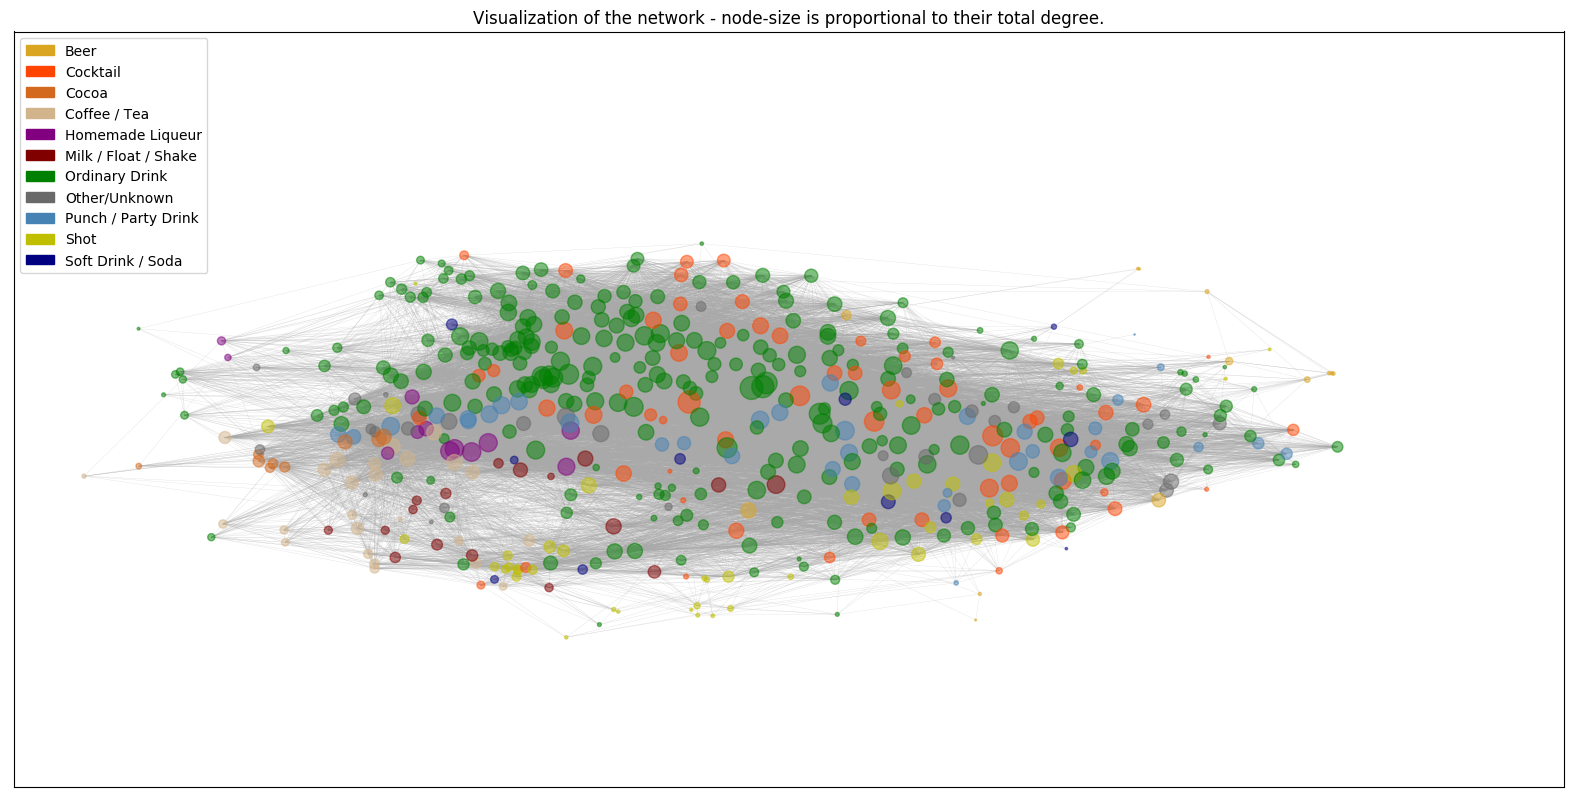

In [11]:
patches = []
for i, c in enumerate(unique_categories):
    patches.append(mpatches.Patch(color=col_list[i], label=c))

plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[v for v in d.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their total degree.')
    
plt.show()

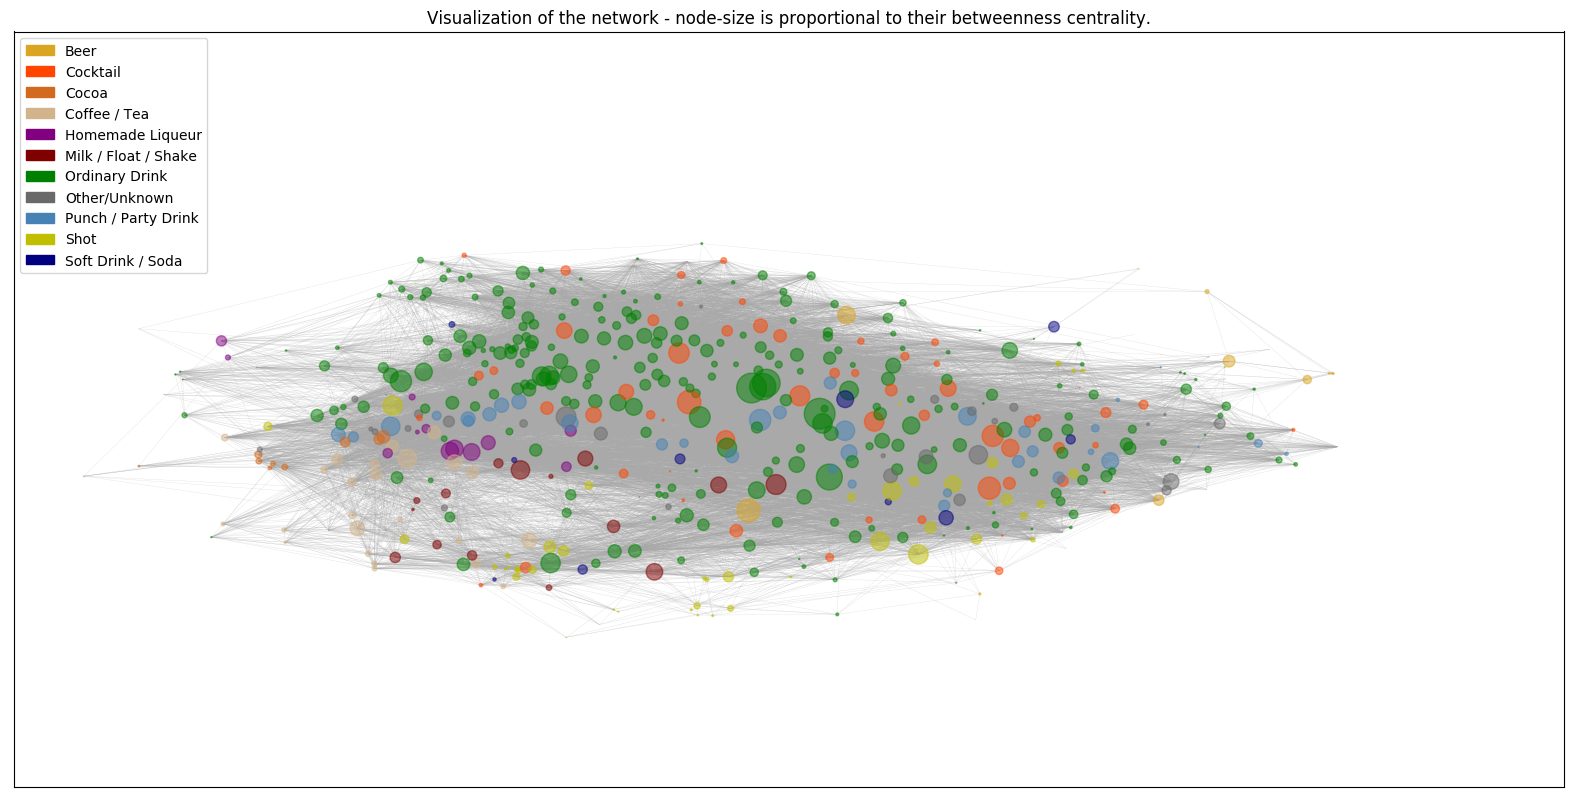

In [12]:
b = nx.betweenness_centrality(G)
plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[30000 * v for v in b.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their betweenness centrality.')
    
plt.show()

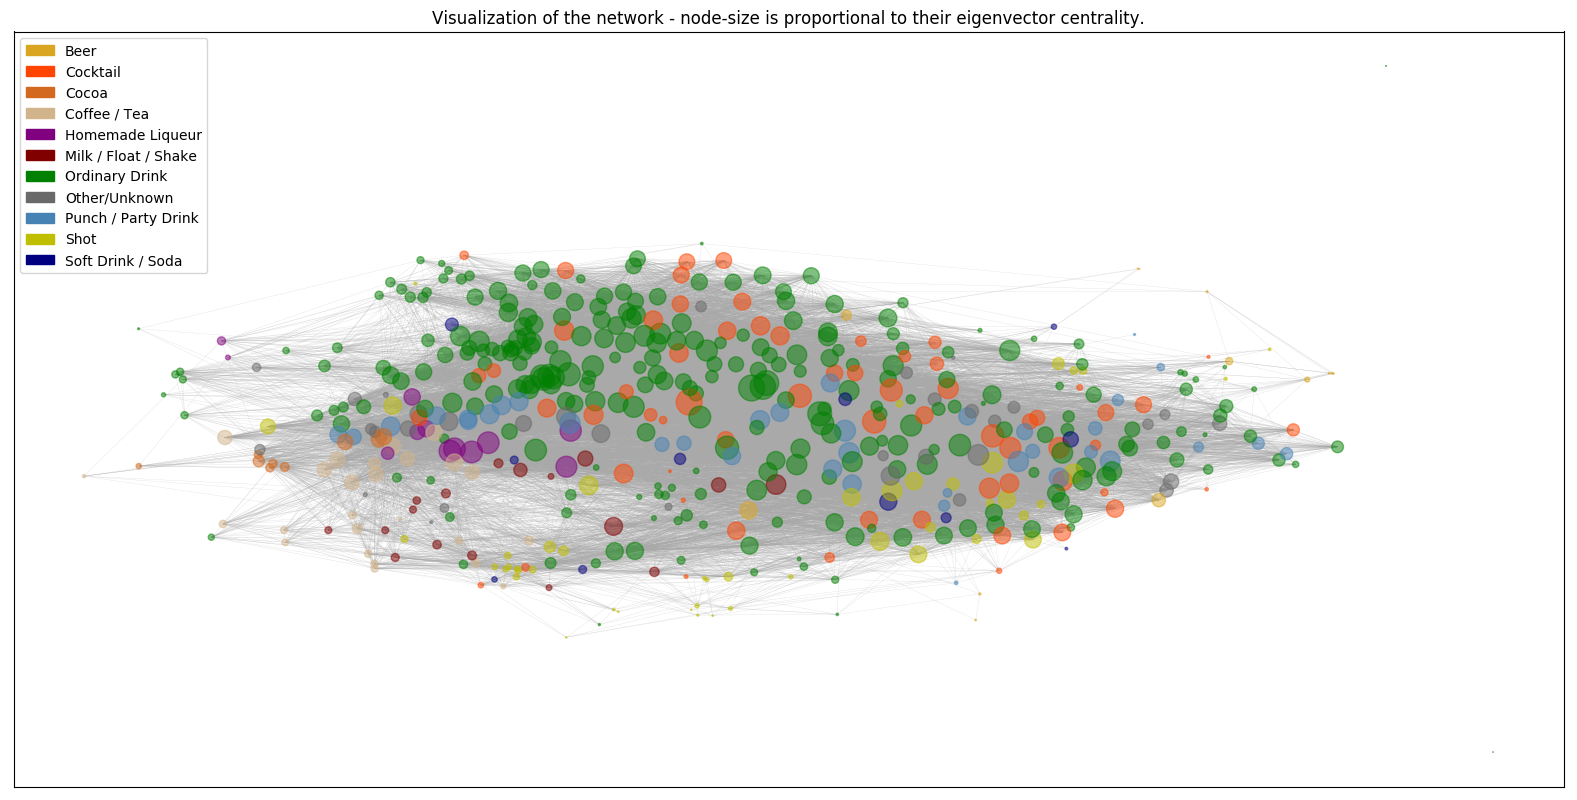

In [13]:
e = nx.eigenvector_centrality(G)
plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[3000 * v for v in e.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the network - node-size is proportional to their eigenvector centrality.')
    
plt.show()

## Community Detection

In this section, we perform community detection on our network using Louvain algorithm. We conduct further analysis on the main characteristics for the obtained communities, and reflect these results with existing drink categories and glass types. 

In [14]:
# Use the Louvain algorithm for community detection
# set random state for reproductibility
partition = community.best_partition(G, random_state=4)
# Calculate modularity
mod = community.modularity(partition, G)

print('Modularity: {}'.format(mod))

Modularity: 0.364737222612753


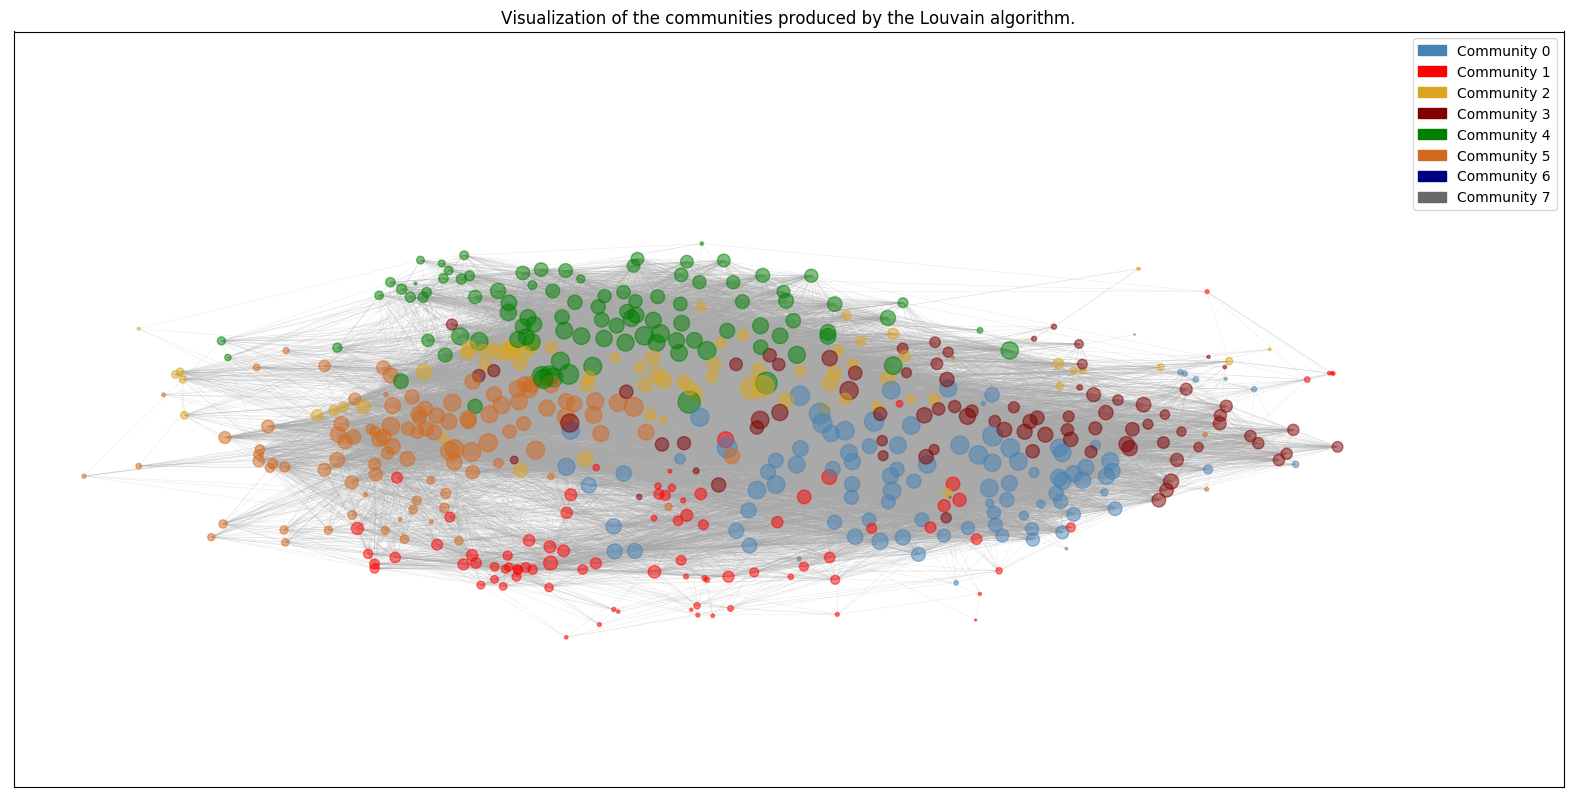

In [15]:
from matplotlib.pyplot import cm


n_of_communities = max(partition.values())

# Init color array
#cols = np.full(shape=(dim, 4), fill_value=1.000000)
cols = np.empty(shape=len(partition), dtype='<U30')

# List of possible colors
#col_list = cm.rainbow(np.linspace(0,1,n_of_communities + 1))
col_list = np.array(['steelblue', 'red', 'goldenrod', 'maroon', 'green', 'chocolate', 'navy', 'dimgrey'])
#np.random.shuffle(col_list)

patches = []
for i, c in enumerate(range(n_of_communities+1)):
    patches.append(mpatches.Patch(color=col_list[i], label='Community {}'.format(c)))

# Save colors according to the partition
for i, p in partition.items():
    cols[i] = col_list[p]

plt.figure(figsize=(20, 10), dpi=100)
nx.draw_networkx_nodes(G, positions, node_size=[v for v in d.values()], 
        node_color=cols, alpha=0.5)

nx.draw_networkx_edges(G, pos=positions, edge_color= 'darkgray', width = 0.15, arrows=False, alpha = 0.6)

plt.legend(handles=patches)
plt.title('Visualization of the communities produced by the Louvain algorithm.')
plt.show()

Next we construct the confusion matrices for communities - categories and communities - glass-types.

In [16]:
glass_types = df['strGlass']
glass_types = np.array([s.lower() for s in glass_types])  # Non-case sensitive
unique_glass_types = np.unique(glass_types)
unique_glass_types

com_cat = np.zeros(shape=(n_of_communities + 1, len(unique_categories)), dtype='int')
com_glass = np.zeros(shape=(n_of_communities + 1, len(unique_glass_types)), dtype='int')

for i, p in partition.items():
    category = np.where(unique_categories == categories[i])
    glass_type = np.where(unique_glass_types == glass_types[i])
    com_cat[p][category] += 1
    com_glass[p][glass_type] += 1
    
com_cat = pd.DataFrame(com_cat)
com_cat.columns = unique_categories
com_cat = com_cat.T

com_glass = pd.DataFrame(com_glass)
com_glass.columns = unique_glass_types
com_glass = com_glass.T

In [17]:
com_cat

0   1   2   3   4   5  6  7
Beer                   1   7   4   1   0   0  0  0
Cocktail              19   8   5  14  14   4  0  0
Cocoa                  0   0   0   0   0   9  0  0
Coffee / Tea           0   7   0   0   0  18  0  0
Homemade Liqueur       2   0   0   0   2   8  0  0
Milk / Float / Shake   2   5   2   1   0   7  0  0
Ordinary Drink        46  28  53  37  84  26  1  0
Other/Unknown          2   1   2  11   0  17  0  1
Punch / Party Drink    9   1   3  14   0  10  0  0
Shot                  14  26   4   1   1   3  0  0
Soft Drink / Soda      3   2   1   5   0   0  0  0

In [18]:
com_glass

0   1   2   3   4   5  6  7
beer glass                 0   0   2   0   0   0  0  0
beer mug                   1   2   1   2   0   0  0  0
beer pilsner               1   1   3   0   0   0  0  0
brandy snifter             0   0   1   0   0   2  0  0
champagne flute            6   0   0   1   0   6  0  0
cocktail glass            13  15  24  18  51   4  0  0
coffee mug                 0   5   0   0   0  18  0  0
collins glass             21  15   9  21  10  17  0  0
copper mug                 1   0   0   0   0   0  0  0
cordial glass              0   0   0   0   1   0  0  0
highball glass            20   6   9  25  17  27  1  1
hurricane glass            2   0   2   2   1   0  0  0
irish coffee cup           1   1   0   0   1   3  0  0
jar                        1   0   0   0   0   0  0  0
margarita glass            0   1   0   0   0   0  0  0
margarita/coupette glass   1   1   1   1   0   0  0  0
martini glass              0   0   0   0   3   0  0  0
mason jar                  0   0   0   0   0   2  0  0
old-fashioned glass       10  10  10   3  12  10  0  0
parfait glass              0   0   0   0   0   1  0  0
pint glass                 1   5   0   1   0   0  0  0
pitcher                    1   0   0   1   0   3  0  0
pousse cafe glass          0   1   0   1   0   0  0  0
punch bowl                 5   0   1   4   0   2  0  0
shot glass                 8  21   4   1   0   3  0  0
whiskey sour glass         1   0   7   1   4   4  0  0
white wine glass           2   0   0   1   1   0  0  0
wine glass                 2   1   0   1   0   0  0  0

Next, we construct the corresponding row- and columnwise heatmaps to visualize the confusion matrices.

In [19]:
import seaborn as sns; sns.set()

# Relative to rows

cat_row = com_cat.copy()
glass_row = com_glass.copy()

# Relative to cols

cat_col = com_cat.copy()
glass_col = com_glass.copy()

In [20]:
for i in range(cat_row.shape[0]):
    row = np.array(cat_row.iloc[i,:])
    s = np.sum(row)
    cat_row.iloc[i,:] = row / s
    
for i in range(cat_col.shape[1]):
    col = np.array(cat_col.iloc[:,i])
    s = np.sum(col)
    cat_col.iloc[:,i] = col / s

In [21]:
for i in range(glass_row.shape[0]):
    row = np.array(glass_row.iloc[i,:])
    s = np.sum(row)
    glass_row.iloc[i,:] = row / s
    
for i in range(glass_col.shape[1]):
    col = np.array(glass_col.iloc[:,i])
    s = np.sum(col)
    glass_col.iloc[:,i] = col / s

#### Heatmap of the communities w.r.t. to the corresponding categories. Results on the left are scaled by the row-sums of the confusion matrix and the results on the right are scaled by column-sums.

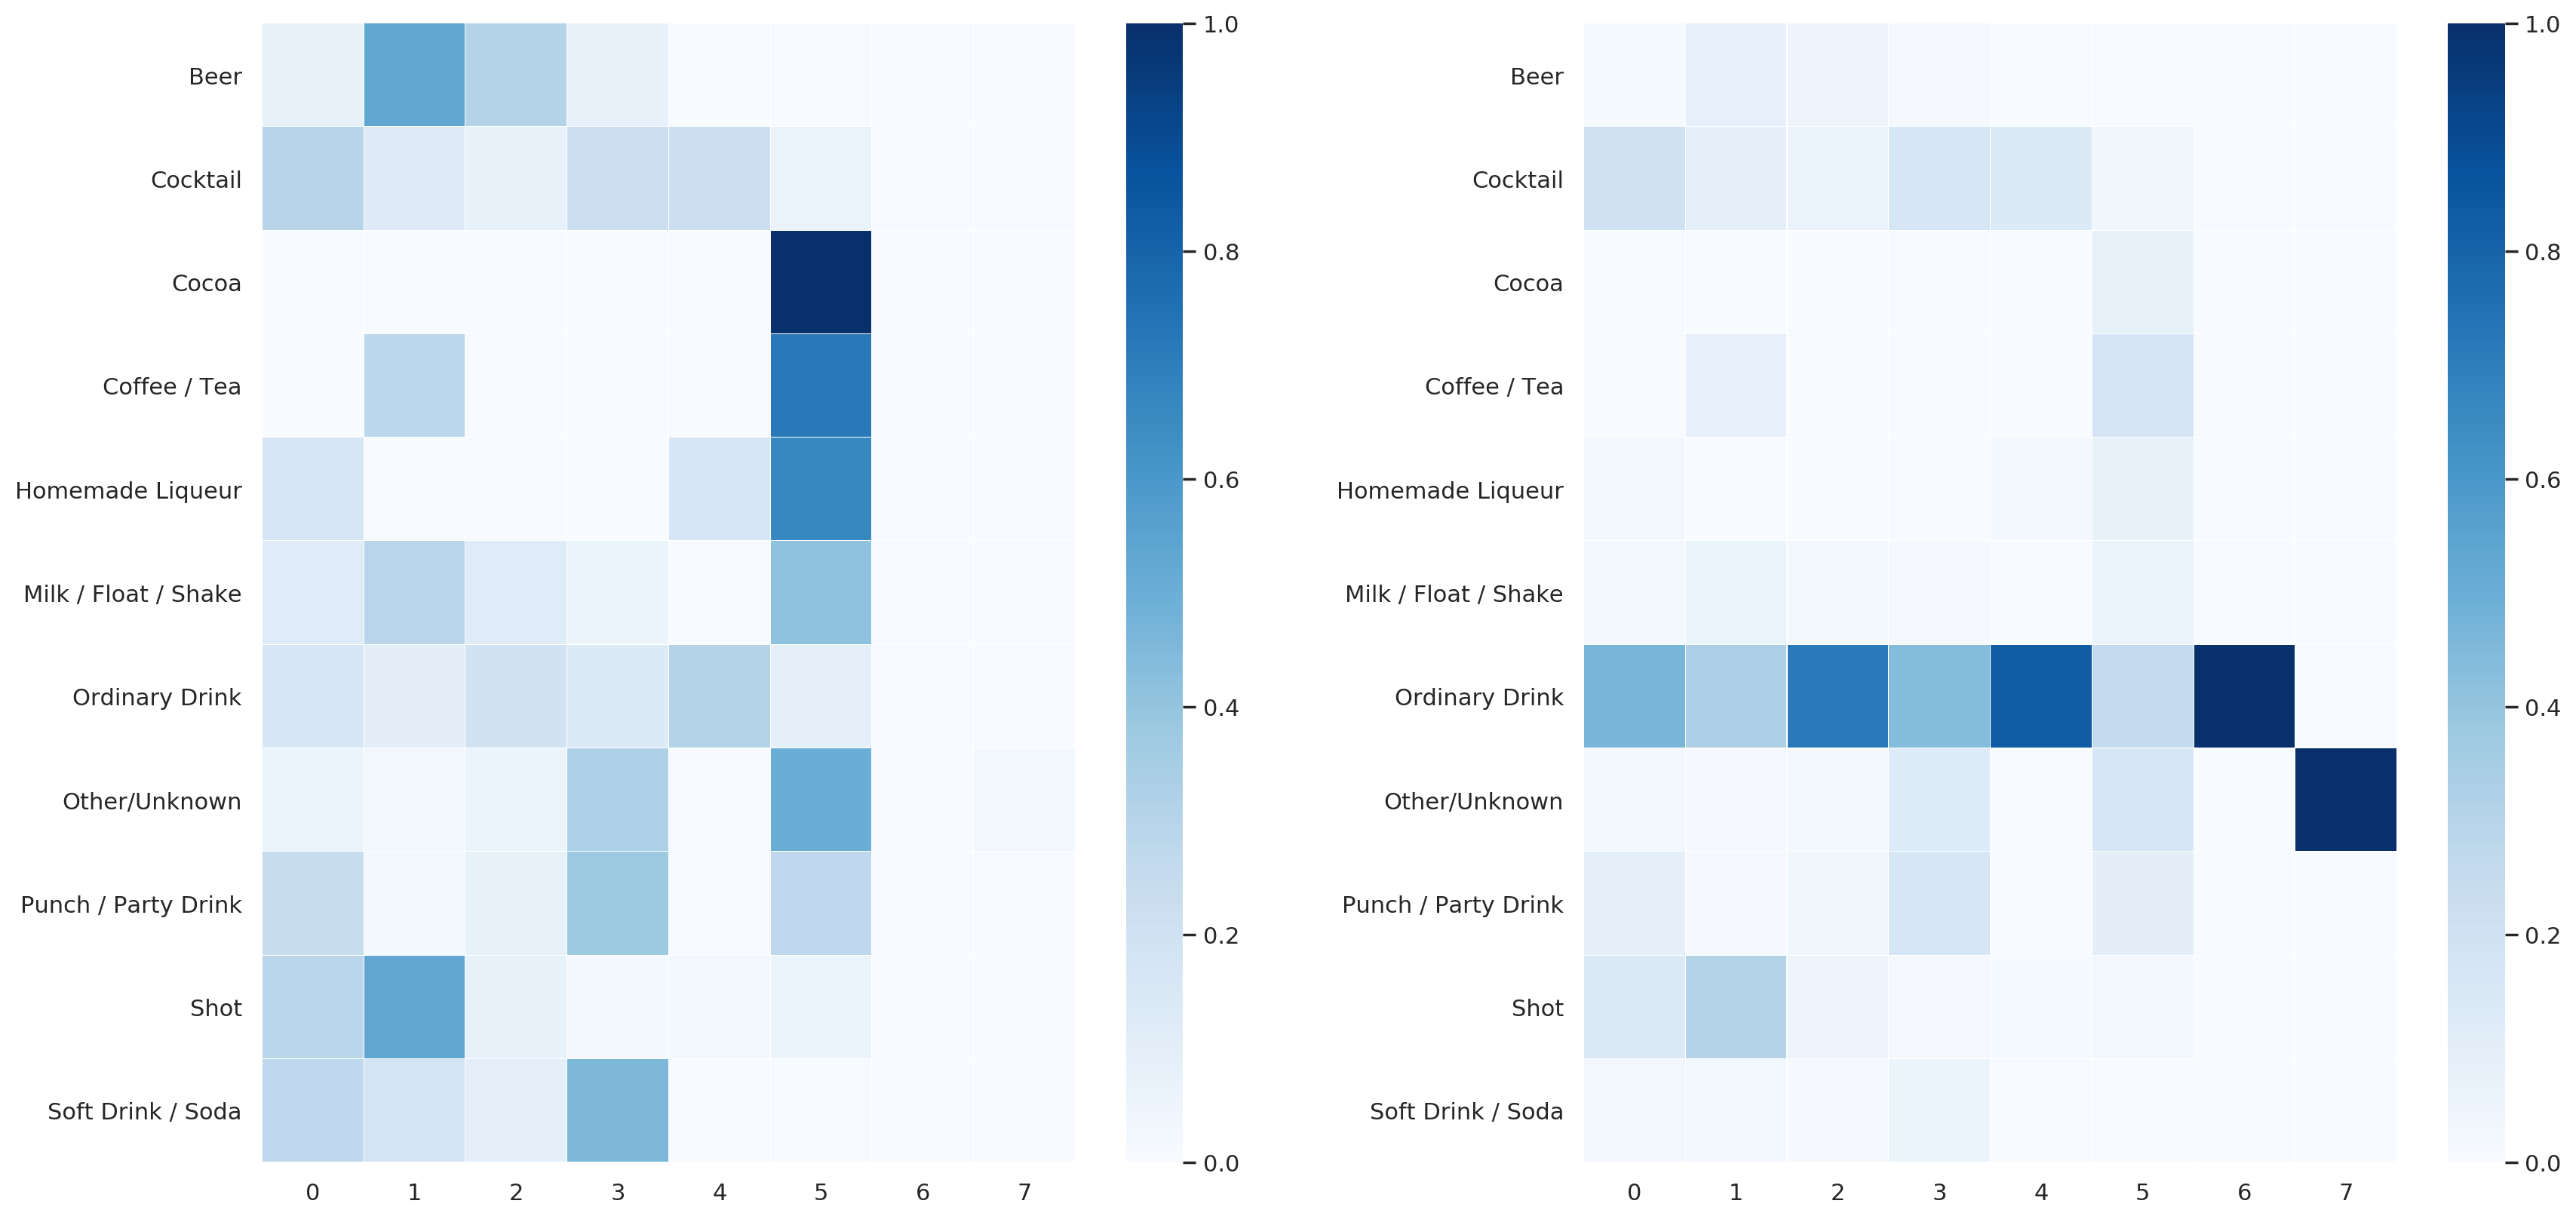

In [22]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(cat_row, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(cat_col, linewidths = .01, cmap="Blues", ax=axs[1])

#### Heatmap of the communities w.r.t. to the corresponding glass-types. Results on the left are scaled by the row-sums of the confusion matrix and the results on the right are scaled by column-sums.

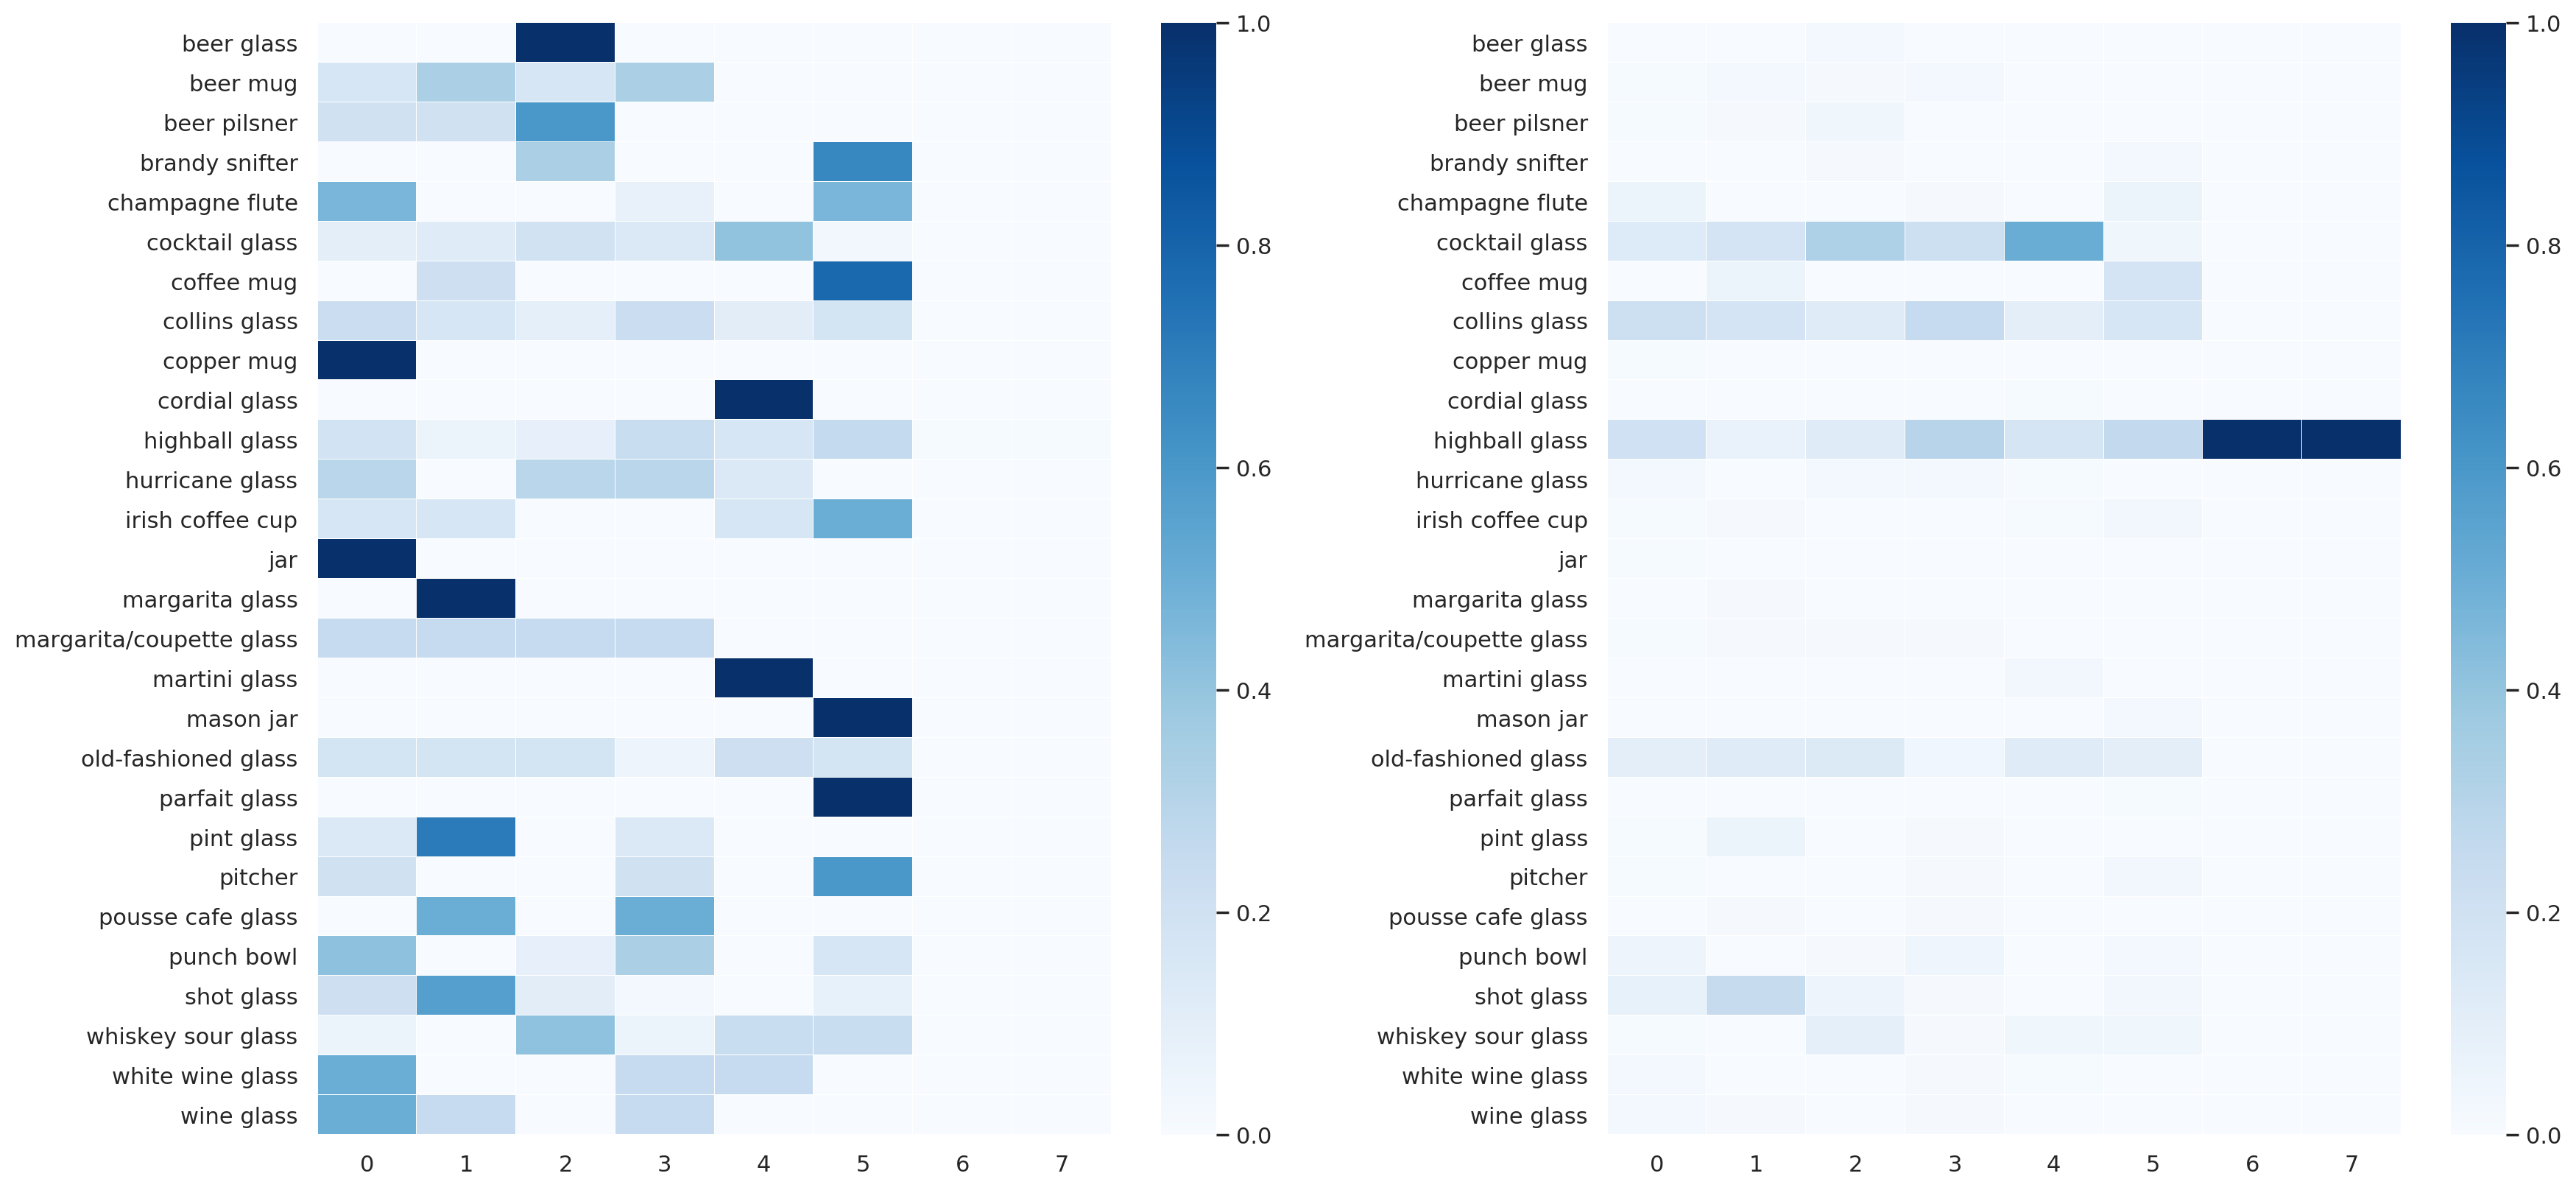

In [23]:
fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1,1]}, figsize=(20, 10), dpi=200)
plt.subplots_adjust(wspace=0.3)

sns.heatmap(glass_row, linewidths = .01, cmap="Blues", ax=axs[0])
sns.heatmap(glass_col, linewidths = .01, cmap="Blues", ax=axs[1])

From the confusion matrix and its visualizations it can be seen that while the communities do not generally correspond to drink categories or glass-types, for some specific categories and glass-types the correlation does indeed exist. 

### Categories

Most prominent associations between communities and categories are the following

- Beer $\rightarrow 1$
- Cocktail $\rightarrow 1$
- Cocoa $\rightarrow 5$
- Coffee / Tea $\rightarrow 5$
- Homemade Liqueur $\rightarrow 5$
- Other/Unknown $\rightarrow 5$
- Punch / Party Drink $\rightarrow 3$
- Shot $\rightarrow 1$
- Soft Drink / Soda $\rightarrow 3$

and

- $0 \rightarrow$ Ordinary Drink
- $2 \rightarrow$ Ordinary Drink
- $4 \rightarrow$ Ordinary Drink
- $6 \rightarrow$ Ordinary Drink
- $7 \rightarrow$ Other/Unknown.

Interestingly, many categories with a smaller number of drinks are associated with community 5. As all drinks of Cocoa-category are placed in this community, the other drinks in this community are probably associated with cocoa-style ingredients.

Here, it is noteworthy, that the community $\rightarrow$ Category associations do not necessarily represent 'meaningful' associations since Ordinary Drink is clearly the largest drink category. Same logic holds also for the two last associations since communities 6 and 7 have only one observations in them.

### Glass-types

The most prominent associations between communities and glass types are the following:

- Beer Glass $\rightarrow 2$
- Copper Mug $\rightarrow 0$
- Cordial Glass $\rightarrow 4$
- Jar $\rightarrow 3$
- Margarita Glass $\rightarrow 3$
- Martini Glass $\rightarrow 3$
- Mason Jar $\rightarrow 3$
- Parfait Glass $\rightarrow 3$

Similarly as with categories, some of these associations are concerned with glass-types or communities that have a support of very few observations and do not necessarily correspond to 'meaningful' correlations.

To properly account for the effect of the size of communities and categories/glass-types, we proceed on conducting an association rule analysis on the data.

In [24]:
transactions_cat = []
transactions_glass = []

for i, c in partition.items():
    
    category = categories[i]
    glass_type = glass_types[i]
    transactions_cat += [(c, category)]
    transactions_glass += [(c, glass_type)]
    
transactions_cat = np.array(transactions_cat)
transactions_glass = np.array(transactions_glass)

In [25]:
from mlxtend.frequent_patterns import apriori, association_rules

items_cat = np.unique(transactions_cat)
items_glass = np.unique(transactions_glass)

In [26]:
def encode(df, items):
    encoded_vals = []
    for index, row in df.iterrows():
        labels = {}
        uncommons = list(set(items) - set(row))
        commons = list(set(items).intersection(row))
        for uc in uncommons:
            labels[uc] = 0
        for com in commons:
            labels[com] = 1
        encoded_vals.append(labels)
    encoded_vals[0]
    return pd.DataFrame(encoded_vals)

In [27]:
df_cat = pd.DataFrame(transactions_cat)
df_glass = pd.DataFrame(transactions_glass)

ohe_cat = encode(df_cat, items_cat)
ohe_glass = encode(df_glass, items_glass)

In [28]:
# min_support=0.002 filters out the 1-observation communities

freq_items_cat = apriori(ohe_cat, min_support=0.002, use_colnames=True, verbose=1)
freq_items_glass = apriori(ohe_glass, min_support=0.002, use_colnames=True, verbose=1)

Processing 546 combinations | Sampling itemset size 3
Processing 1611 combinations | Sampling itemset size 3


In [29]:
rules_cat = association_rules(freq_items_cat, metric="confidence", min_threshold=0.5)
rules_cat

antecedents       consequents  antecedent support  \
0              (Beer)               (1)            0.023810   
1              (Shot)               (1)            0.089744   
2                 (2)  (Ordinary Drink)            0.135531   
3                 (4)  (Ordinary Drink)            0.184982   
4             (Cocoa)               (5)            0.016484   
5      (Coffee / Tea)               (5)            0.045788   
6  (Homemade Liqueur)               (5)            0.021978   
7     (Other/Unknown)               (5)            0.062271   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.155678  0.012821    0.538462  3.458824  0.009114    1.829365  
1            0.155678  0.047619    0.530612  3.408403  0.033648    1.798774  
2            0.503663  0.097070    0.716216  1.422015  0.028808    1.748997  
3            0.503663  0.153846    0.831683  1.651269  0.060678    2.948826  
4            0.186813  0.016484    1.000000  5.352941  0.013404         inf  
5            0.186813  0.032967    0.720000  3.854118  0.024413    2.904239  
6            0.186813  0.014652    0.666667  3.568627  0.010546    2.439560  
7            0.186813  0.031136    0.500000  2.676471  0.019502    1.626374

In [30]:
rules_glass = association_rules(freq_items_glass, metric="confidence", min_threshold=0.5)
rules_glass

antecedents       consequents  antecedent support  \
0   (white wine glass)               (0)            0.007326   
1         (wine glass)               (0)            0.007326   
2         (pint glass)               (1)            0.012821   
3         (shot glass)               (1)            0.067766   
4         (beer glass)               (2)            0.003663   
5       (beer pilsner)               (2)            0.009158   
6                  (4)  (cocktail glass)            0.184982   
7      (martini glass)               (4)            0.005495   
8     (brandy snifter)               (5)            0.005495   
9         (coffee mug)               (5)            0.042125   
10  (irish coffee cup)               (5)            0.010989   
11         (mason jar)               (5)            0.003663   
12           (pitcher)               (5)            0.009158   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.179487  0.003663    0.500000  2.785714  0.002348    1.641026  
1             0.179487  0.003663    0.500000  2.785714  0.002348    1.641026  
2             0.155678  0.009158    0.714286  4.588235  0.007162    2.955128  
3             0.155678  0.038462    0.567568  3.645787  0.027912    1.952495  
4             0.135531  0.003663    1.000000  7.378378  0.003167         inf  
5             0.135531  0.005495    0.600000  4.427027  0.004253    2.161172  
6             0.228938  0.093407    0.504950  2.205624  0.051057    1.557546  
7             0.184982  0.005495    1.000000  5.405941  0.004478         inf  
8             0.186813  0.003663    0.666667  3.568627  0.002637    2.439560  
9             0.186813  0.032967    0.782609  4.189258  0.025098    3.740659  
10            0.186813  0.005495    0.500000  2.676471  0.003442    1.626374  
11            0.186813  0.003663    1.000000  5.352941  0.002979         inf  
12            0.186813  0.005495    0.600000  3.211765  0.003784    2.032967

Association rule mining with 0.5 confidence performed on the partition data (with filtering out itemsets with less than 0.002 support, i.e. one-observation communities) seems to conduct somewhat similar results as the analysis of confusion matrix/heatmaps in terms of the most relevant associations. The correlation to previos analysis is, however, clearly stronger for categories as it is for glass-types. This kind of result is expected as glass-types with really low support were more common than categories with similarly low support.

Here, it is noteworthy that the association rules represented here are directional, while relevance of an association, in this context, isn't necessarily defined only by strength of an one directional mapping but should rather reflect the strength of a bijective mapping.

Next we construct wordclouds for each community to better understand the underlying characteristics of these communities.

First, we'll parse the ingredients to form 'documents' for each community.

In [31]:
punctuation = string.punctuation + '…'

def map_punctuation(s):
    return np.array([char not in punctuation for char in s])

token_arrays = np.empty(n_of_communities+1,object)
token_arrays.fill([])

for i, row in enumerate(data):
    partition_i = list(partition.values())[i]
    #s = row[23] # For instructions
    s = " ".join([i for i in row[8:23] if isinstance(i, str)]) # For ingredients
    if isinstance(s, str):
        tokens = word_tokenize(s)
        # Remove numbers
        tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
        # Remove punctuation
        tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
        # Remove stopwords
        tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
        for token in tokens:
            token_arrays[partition_i] = np.append(token_arrays[partition_i], token)
    

Here, we calculate the tf-idf values for each word in each document and construct the wordclouds based on those values.

In [32]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))

In [33]:
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp

In [34]:
wordclouds = []

for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    s = " ".join(w)

    wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(s)
    wordclouds.append(wordcloud)


### Community-ingredients wordcloud visualizations:

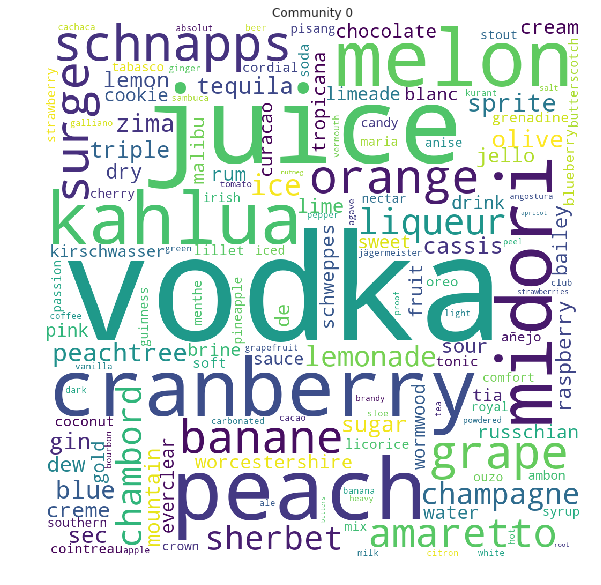

In [35]:
i = 0
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Based on the wordcloud, community 0 seems to contain mostly fresh, vodka-based drinks with fruity/sweet flavors. This is consistent with the previous analysis as the community should consist mostly of ordinary drinks, cocktails, punches and party drinks.

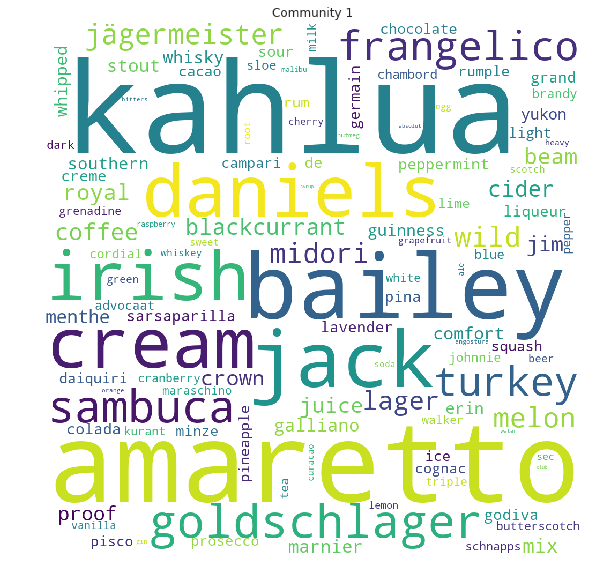

In [36]:
i = 1
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Community 1 seems to contain variety of different whiskeys and other strong tastes combined with occasional soft, creamy alcohols. Based on previous analysis, this community is expected to have mostly shots and ordinary drinks.

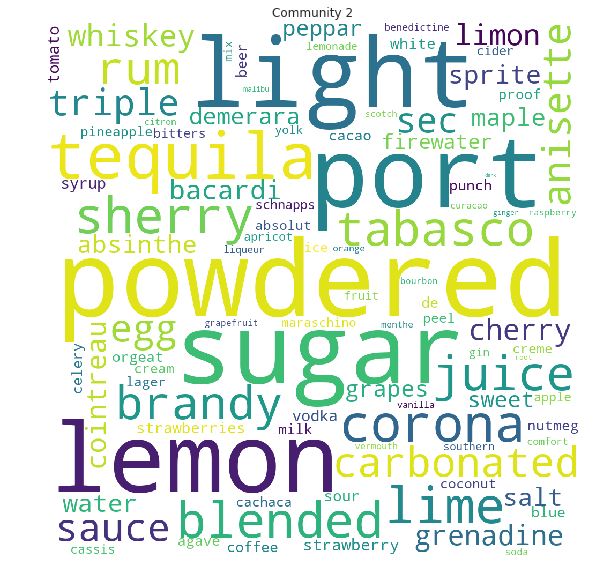

In [37]:
i = 2
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

This community seems to have sour but yet sweet tastes (lemon, lime) in its most ingredients combined with spicy tastes of tabasco and tequila. It is reasonable that these ingredients are grouped in their own community as it is common to see them together.

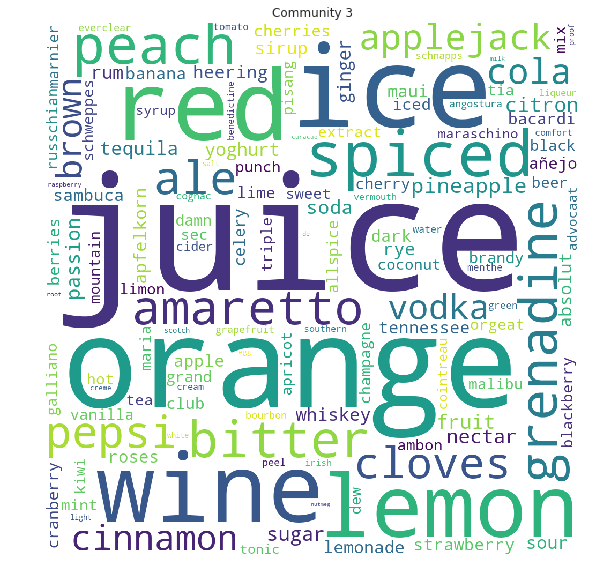

In [38]:
i = 3
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Community 3 seems to have a wide variety of mostly wine and/or orange(juice) based drinks.

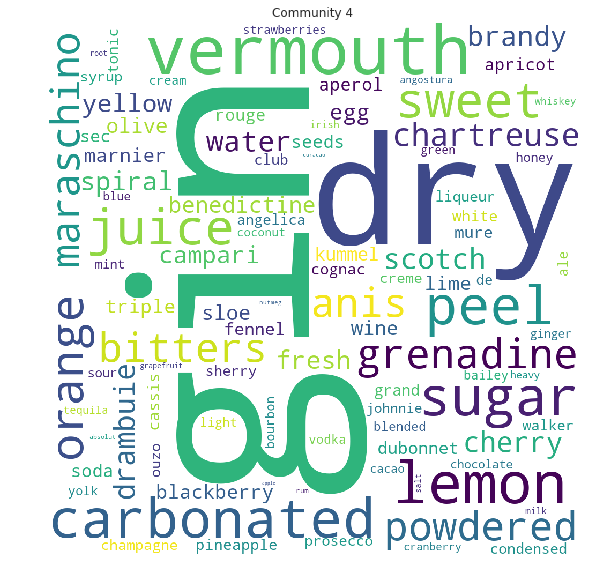

In [39]:
i = 4
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Community 4 seems to be mostly about dry and bitter drinks with gin and vermouth being the most common alcohols. Yet again it is expected to see these ingredients grouped in their own community.

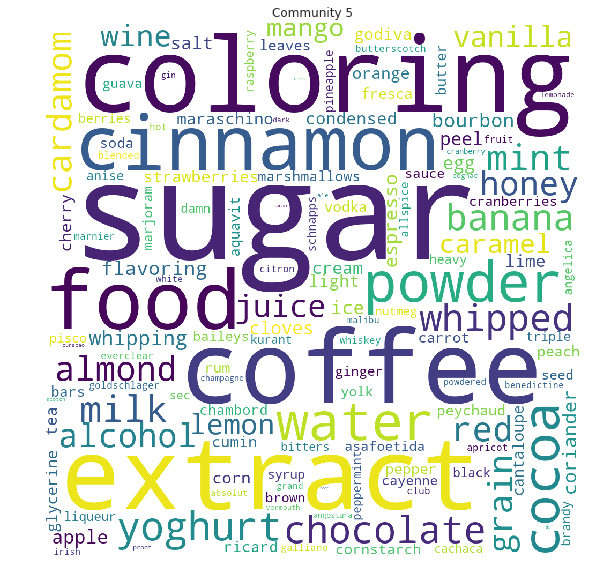

In [40]:
i = 5
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordclouds[i]) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Community {}'.format(i))
  
plt.show() 

Among the most characteristic ingredients in the community 5 seem to include coffee/cocoa/cinnamon/vanilla which seems to be consistent with our previous analysis as this community should contain ingredients that are often associated with cocoa and coffee drinks.

### Concluding analysis:

As previously stated, the communities found with the Louvain algorithm do not have proper overall correspondance to the drink categories nor the glass types. There exists, however, some useful associations, especially between communities and categories, as shown in previous analysis. The lack of direct correspondance is somewhat expected, as the network used for the community detection is based on ingredients and accounting only the ingredients of a drink may not be enough information to determine its category of glass-type. Ingredients do, however, give us useful heuristics in categorizing the drinks based on different aspects, as seen in the wordclouds above. Each community (excluding the one-drink communities), seems to consist of its own, distinct and reasonable 'type-defining' sets of ingredients which are often expected to occur together.

## WordClouds

In [30]:
punctuation = string.punctuation + '…'

def map_punctuation(s):
    return np.array([char not in punctuation for char in s])

token_arrays = np.empty(len(unique_categories),object)
token_arrays.fill([])

In [31]:
# Cleaning DataFrame for multiple instances of same glass type:

df2 = df.copy()

for i, row in df2.iterrows():
    
    row['strGlass'] = row['strGlass'].lower()
    
    if (row['strGlass'] == 'beer mug') or (row['strGlass'] == 'beer pilsner'):
        row['strGlass'] = 'beer glass'
        
    if row['strGlass'] == 'margarita glass':
        row['strGlass'] = 'margarita/coupette glass'
        
    if row['strGlass'] == 'white wine glass':
        row['strGlass'] = 'wine glass'
        
data2 = np.array(df2)

# We extract the list of unique glass types after we have cleaned:

unique_glasses = []
glasses = np.array(df2['strGlass'])

unique_glasses_temp, counts_temp = np.unique(glasses, return_counts=True)
c = np.asarray((unique_glasses_temp, counts_temp)).T

for i in range(len(unique_glasses_temp)):
    if counts_temp[i] > 7:                #Only including glasstype of occuring over 7 times
        unique_glasses.append(unique_glasses_temp[i])


unique_glasses = np.array(unique_glasses)
unique_glasses

array(['beer glass', 'champagne flute', 'cocktail glass', 'coffee mug',
       'collins glass', 'highball glass', 'old-fashioned glass',
       'punch bowl', 'shot glass', 'whiskey sour glass', 'wine glass'],
      dtype='<U19')

### Instructions-Glasstype

In [32]:
# Glass types is found in column 6

for i, row in enumerate(data2):
    if row[6] in unique_glasses:
        glass_i = np.where(unique_glasses == row[6])[0][0] # This line finds which index in unique_glasses, this is
        s = row[23] # s is the instruction
        if isinstance(s, str):
            tokens = word_tokenize(s)
            # Remove Numbers:
            tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
            # Remove Punctuation:
            tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
            # Remove Stopwords:
            tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
            for token in tokens:
                token_arrays[glass_i] = np.append(token_arrays[glass_i], token)          

In [33]:
# We now have an array of arrays. Each array corresponds to a glass-type in unique_glasses
# I.e. token_arrays[0] corresponds to all the words in Instructions for unique_glasses[0] which is "Beer Glass"

token_arrays[0]

array(['drop', 'shooter', 'glass', 'fill', 'beer', 'combine',
       'ingredients', 'blend', 'smooth', 'garnish', 'chocolate',
       'shavings', 'desired', 'fill', 'glass', 'ice', 'fish', 'add',
       'vodka', 'grape', 'soda', 'orange', 'juice', 'do', 'not', 'stir',
       'serve', 'well', 'chilled', 'carefully', 'avoid', 'explosive',
       'head', 'formation', 'pour', 'beer', 'glass', 'half', 'full',
       'favorite', 'rootbeer', 'top', 'guinness', 'scoop', 'two', 'large',
       'scoops', 'vanilla', 'frosted', 'beer', 'mug', 'next', 'add',
       'ounces', 'maker', 'mark', 'then', 'pour', 'coke', 'gently',
       'stir', 'enjoy', 'pour', 'corona', 'beer', 'glass', 'pour',
       'bacardi', 'limon', 'beer', 'stir', 'gently', 'blend', 'together',
       'blender', 'serve', 'chilled', 'beer', 'mug', 'fresh',
       'blueberries', 'caramel', 'topping', 'use', 'oz', 'glass', 'add',
       'campari', 'first', 'fill', 'beer', 'pour', 'corona', 'beer',
       'glass', 'pour', 'rum', 'bee

In [34]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))

In [35]:
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp
    
tf_idfs[0][:10]

[('beer', 0.05532072847436888),
 ('bottle', 0.03629228870069823),
 ('corona', 0.03062919662230074),
 ('turn', 0.014516915480279292),
 ('mug', 0.011064145694873776),
 ('whisky', 0.01020973220743358),
 ('unplug', 0.01020973220743358),
 ('thumb', 0.01020973220743358),
 ('specific', 0.01020973220743358),
 ('real', 0.01020973220743358)]

In [36]:
# Create Masks

response_beer = requests.get('https://c7.uihere.com/files/898/72/993/carlsberg-group-beer-glasses-copenhagen-beer.jpg')
mask_beer = np.array(PIL.Image.open(BytesIO(response_beer.content)))

response_champagne = requests.get('http://clipartbarn.com/wp-content/uploads/2016/12/Champagne-glass-champagne-january-clipart-kid.jpg')
mask_champagne = np.array(PIL.Image.open(BytesIO(response_champagne.content)))
    
response_cocktail = requests.get('https://carlisletheacarlisletheatre.org/images/martini-glass-clipart-wine-2.png')
mask_cocktail = np.array(PIL.Image.open(BytesIO(response_cocktail.content)))

In [37]:
use_masks = True

wordclouds = []

for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    str1 = " ".join(w)
    
    if use_masks:
        if unique_glasses[i] == 'beer glass':
            wordcloud = WordCloud(collocations=False, mask=mask_beer, background_color='white', width=1000, height=1000).generate(str1)
        elif unique_glasses[i] == 'champagne flute':
            wordcloud = WordCloud(collocations=False, mask=mask_champagne, background_color='white', width=1000, height=1000).generate(str1)
        elif unique_glasses[i] == 'cocktail glass':
            wordcloud = WordCloud(collocations=False, mask=mask_cocktail, background_color='white', width=1000, height=1000).generate(str1)
        else:
            wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
            
    else: 
        wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
        
    wordclouds.append(wordcloud)
    
    print(unique_glasses[i])

beer glass
champagne flute
cocktail glass
coffee mug
collins glass
highball glass
old-fashioned glass
punch bowl
shot glass
whiskey sour glass
wine glass


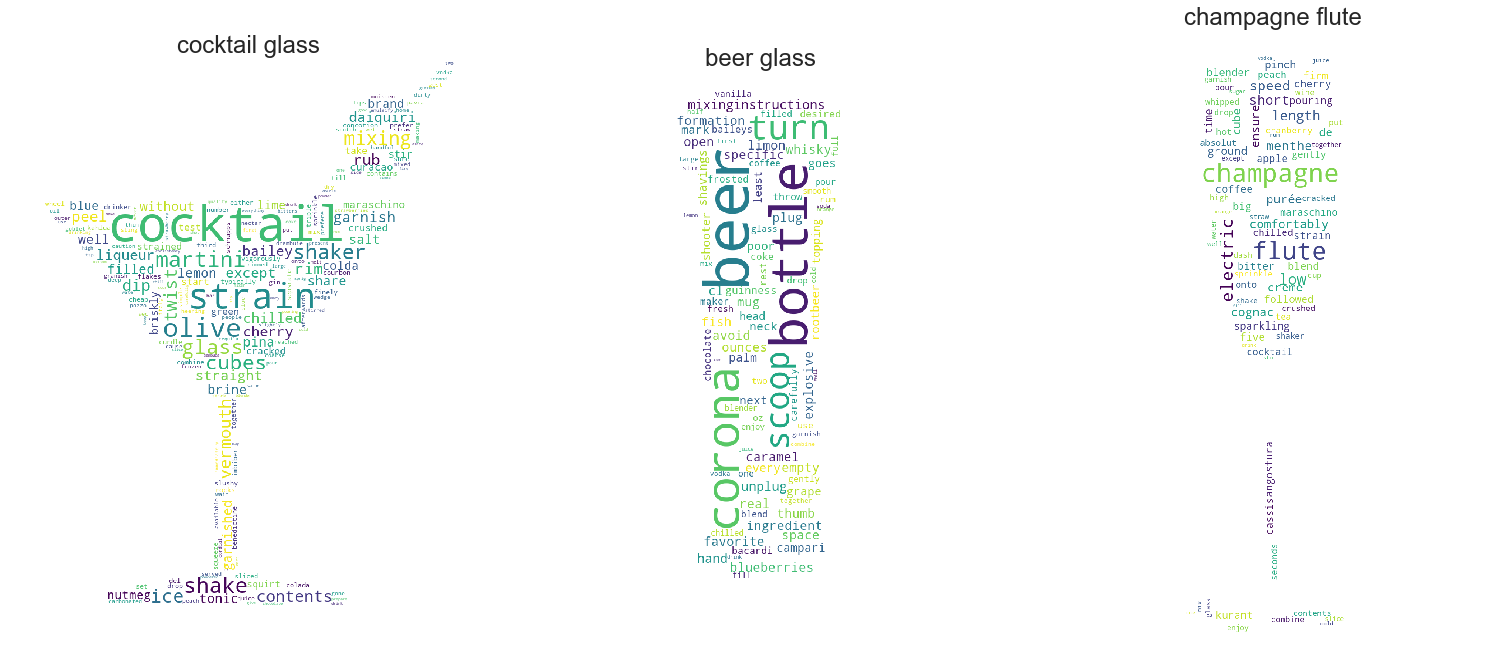

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(26,16))
ax1.imshow(wordclouds[2])
ax1.set_title(unique_glasses[2], fontsize=24)
ax2.imshow(wordclouds[0])
ax2.set_title(unique_glasses[0], fontsize=24)
ax3.imshow(wordclouds[1])
ax3.set_title(unique_glasses[1], fontsize=24)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

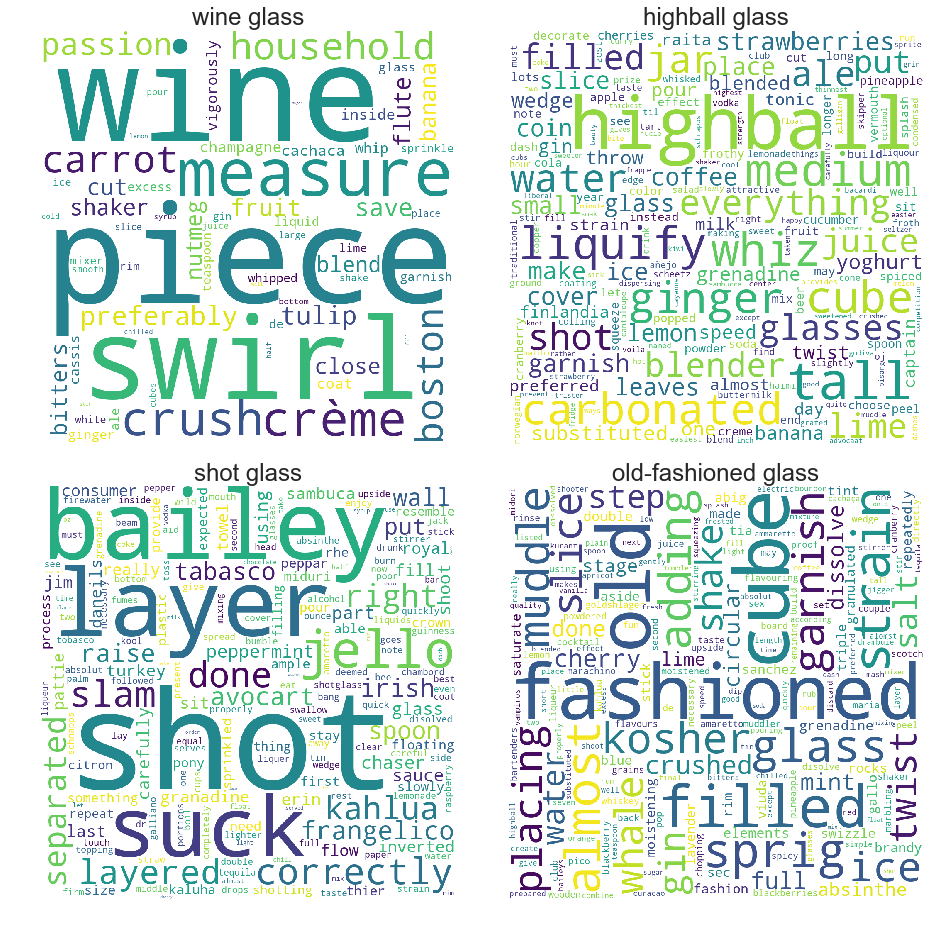

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))

plt.subplots_adjust(wspace=0.1, hspace=0.1)

axs[0, 0].imshow(wordclouds[10])
axs[0, 0].set_title(unique_glasses[10], fontsize=24)
axs[0, 1].imshow(wordclouds[5])
axs[0, 1].set_title(unique_glasses[5], fontsize=24)
axs[1, 0].imshow(wordclouds[8])
axs[1, 0].set_title(unique_glasses[8], fontsize=24)
axs[1, 1].imshow(wordclouds[6])
axs[1, 1].set_title(unique_glasses[6], fontsize=24)

for ax in axs.flat:
    ax.axis('off')

**Wordclouds Instructions-Glasstype:** *The instructions for each glasstype can be seen to differ accordingly. For example the words "strain" and "shake" is used quite often for drinks in cocktail glasses, and never used for drinks in beer glasses, which is to be expected.*

*If one has any experience making Old-Fashioned cocktails, one will know that they always come in their own glass-type. So by looking at the wordcloud for this glass-type, one should see instructions for Old-Fashioned cocktails, which is evident in the fact that words such as 'muddle', 'twist', 'cherry' or 'rocks'.*

*An interesting thing to see is that wine glasses often  seem to hold much more than simply wine. For example, cocktails or cocktail-like drinks seem to be made within wine-glasses quite often, as is evident in the words such as 'crème', 'passion', and 'bitters'.*

### Instructions-Category

In [40]:
unique_categories

array(['Beer', 'Cocktail', 'Cocoa', 'Coffee / Tea', 'Homemade Liqueur',
       'Milk / Float / Shake', 'Ordinary Drink', 'Other/Unknown',
       'Punch / Party Drink', 'Shot', 'Soft Drink / Soda'], dtype=object)

In [41]:
token_arrays = np.empty(len(unique_categories),object)
token_arrays.fill([])

for row in data:
    cat_i = np.where(unique_categories == row[4])[0][0]
    s = row[23]
    if isinstance(s, str):
        tokens = word_tokenize(s)
        # Remove numbers
        tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
        # Remove punctuation
        tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
        # Remove stopwords
        tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
        for token in tokens:
            token_arrays[cat_i] = np.append(token_arrays[cat_i], token)
    

In [42]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))
    
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp
    
tf_idfs[0][:10]

[('bottle', 0.038560556744491874),
 ('pint', 0.032543521411194536),
 ('guiness', 0.032543521411194536),
 ('corona', 0.032543521411194536),
 ('cider', 0.032543521411194536),
 ('beer', 0.024678884510117006),
 ('lager', 0.021695680940796356),
 ('colour', 0.021695680940796356),
 ('blackcurrant', 0.021695680940796356),
 ('bass', 0.021695680940796356)]

In [43]:
wordclouds = []

for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    str1 = " ".join(w)

    wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
    wordclouds.append(wordcloud)
    
    print(unique_categories[i])


Beer
Cocktail
Cocoa
Coffee / Tea
Homemade Liqueur
Milk / Float / Shake
Ordinary Drink
Other/Unknown
Punch / Party Drink
Shot
Soft Drink / Soda


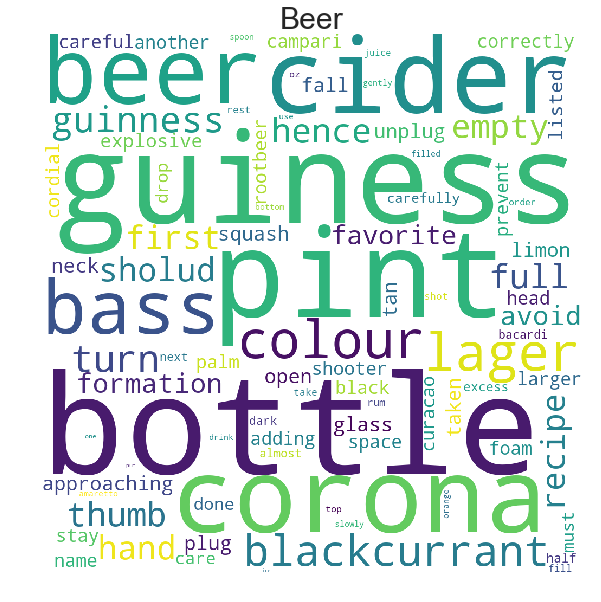

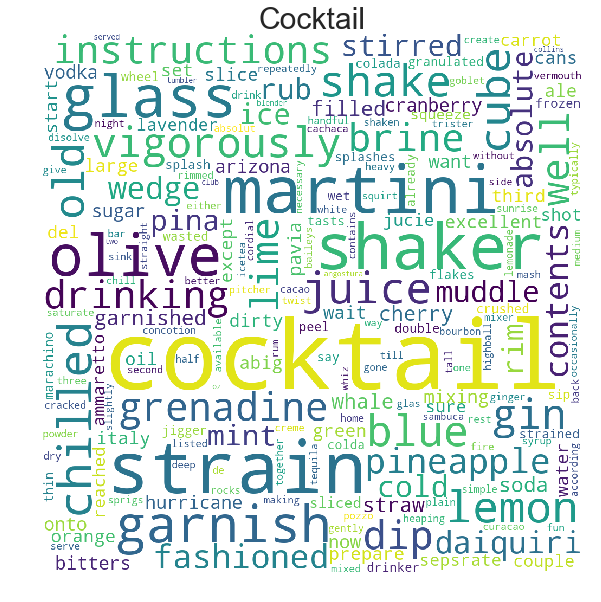

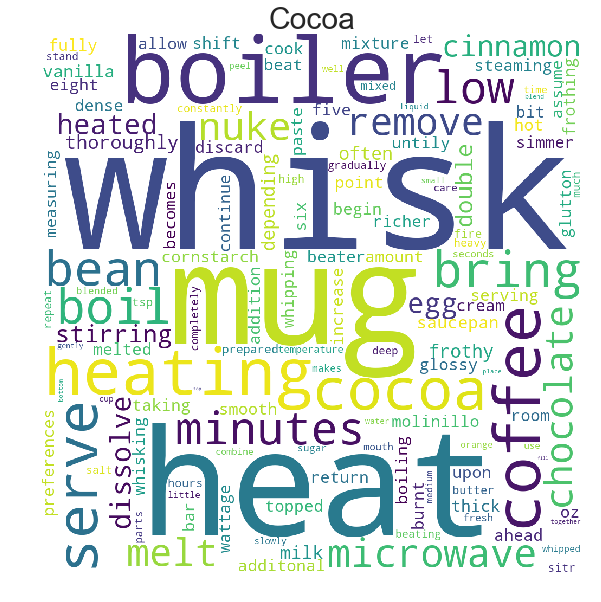

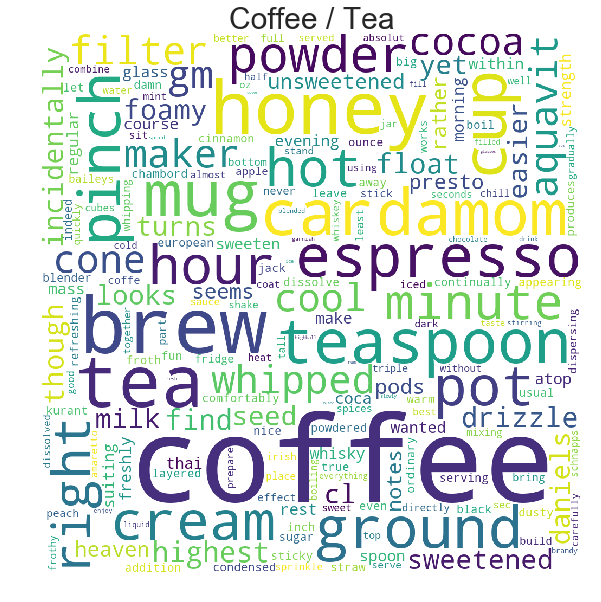

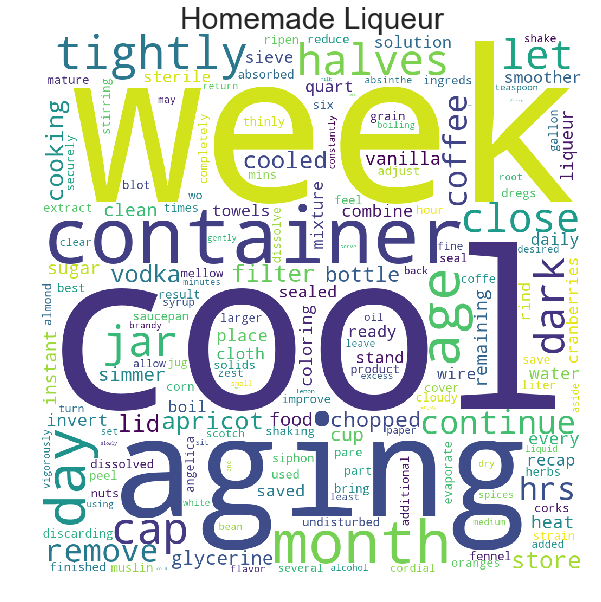

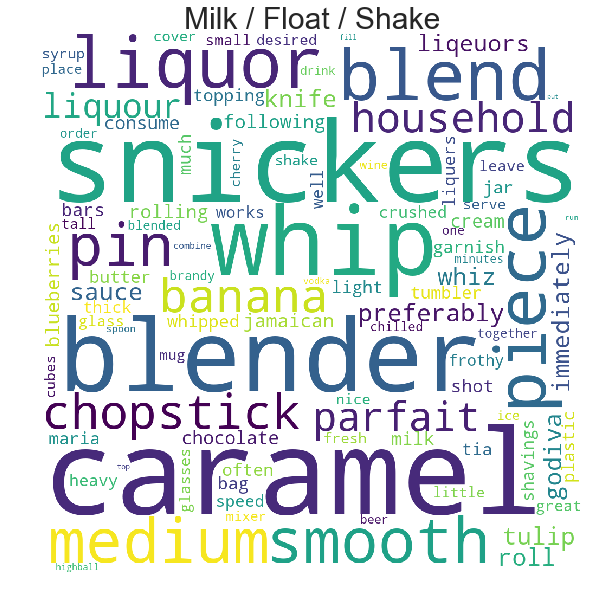

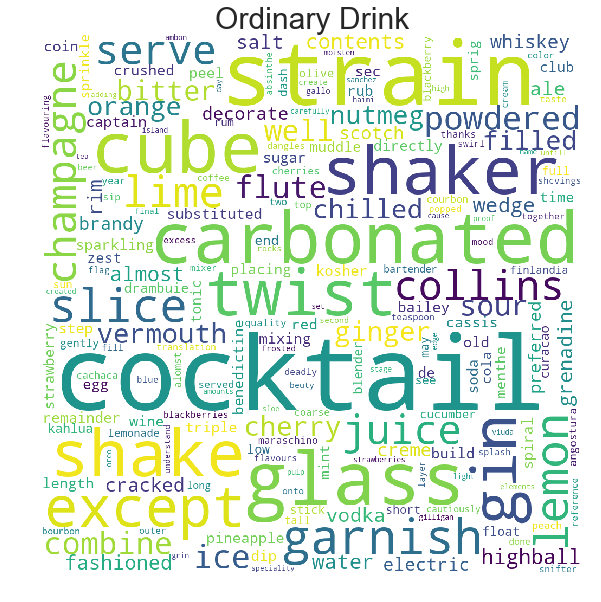

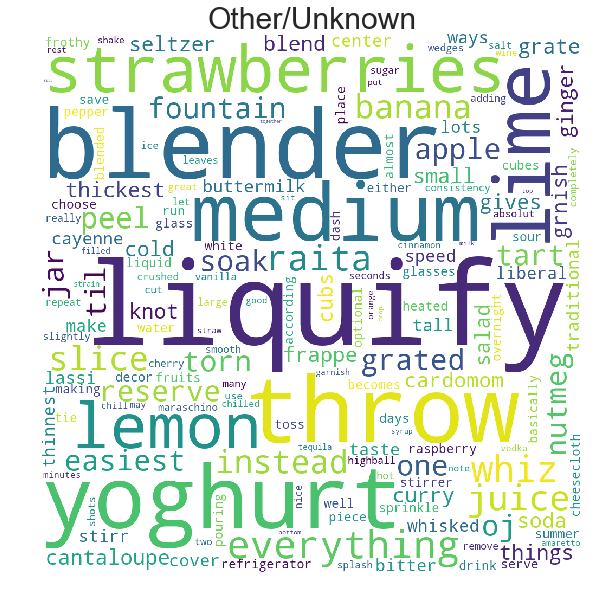

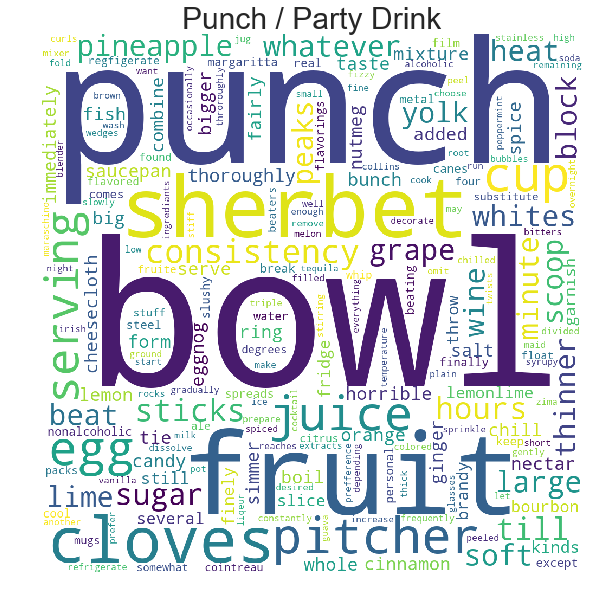

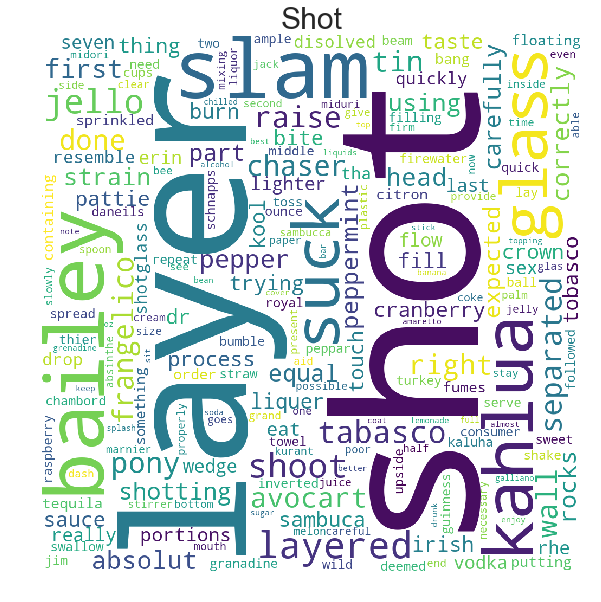

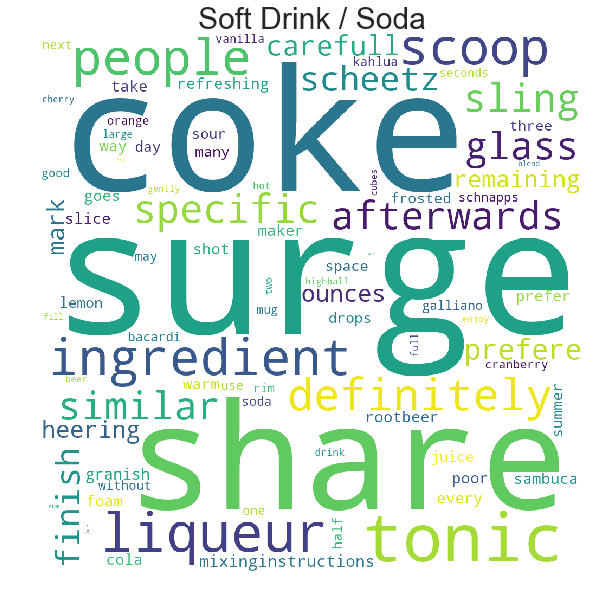

In [44]:
for i in range(len(unique_categories)):

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordclouds[i]) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title(unique_categories[i], fontsize=30)

    plt.show() 

**Instructions-Categories:** There are some interesting observations within the wordclouds for Instructions per category. For instance, when considering "Homemade Liqueur", it's likely that the aging of the alcohol is a higly-valued factor, since the word "aging" has a very high count.
Interestingly enough, the category "Ordinary Drink" seems to contain mostly cocktail-related instructions, with words such as "shake" and "garnish". This implies that "Ordinary Drink" is a label for a drink that doesn't specifically fall into any other category, but will however, often resemble a classic cocktail.

### Ingredients-Categories

In [45]:
# Ingredients is extracted and joined together.

for i, row in enumerate(data):
    cat_i = np.where(unique_categories == row[4])[0][0] # This line finds which index in unique_categories, this is. row[4] is the category in the row
    s = ingredients[i] # s is the ingredients
    s = [i for i in s if isinstance(i, str)]
    s = ' '.join(s)
    if isinstance(s, str):
        tokens = word_tokenize(s)
        # Remove numbers
        tokens = np.array([token for token in tokens if not bool(re.search(r'\d+', token))])
        # Remove punctuation
        tokens = np.array([token.translate(str.maketrans('', '', punctuation)) for token in tokens if all(map_punctuation(token))])
        # Remove stopwords
        tokens = np.array([token.lower() for token in tokens if token not in stopwords.words('english')])
        for token in tokens:
            token_arrays[cat_i] = np.append(token_arrays[cat_i], token)

In [46]:
tf_idfs = []
# Construct a lists of unique tokens for a significant speed-up in calculating idf
unique_lists = []

for tokens in token_arrays:
    unique_lists.append(np.unique(tokens))

for tokens in token_arrays:
    # Get counts for all tokens
    unique, counts = np.unique(tokens, return_counts=True)
    # Calculate tf
    tf = counts / len(counts)
    # Calculate idf
    occurrences = np.array([np.sum([int(token in l) for l in unique_lists]) for token in unique])
    idf = np.log10(len(token_arrays) / occurrences)
    tf_idfs.append(zip(unique, tf * idf))
    
for i in range(len(tf_idfs)):
    tmp = sorted(tf_idfs[i], key=lambda t: t[1])
    tmp.reverse()
    tf_idfs[i] = tmp
    
    

wordclouds = []
for i in range(len(tf_idfs)):
    # Calculate the sum of tf-idf values
    tf_idf_sum = np.sum([tf_idf for _, tf_idf in tf_idfs[i]])
    # Init list for words
    words = []
    # Init list of probabilities for words to occur
    dist_map = []

    # Loop over tuples
    for w, tf_idf in tf_idfs[i]:
        words.append(w)
        dist_map.append(tf_idf / tf_idf_sum)
    
    # Number of iterations
    N = 10000
    # Choose N words according to probabilities proportional to their tf-idf values
    w = np.random.choice(words, N, p=dist_map)
    str1 = " ".join(w)

    wordcloud = WordCloud(collocations=False, background_color='white', width=1000, height=1000).generate(str1)
    wordclouds.append(wordcloud)
    
    print(unique_categories[i])


Beer
Cocktail
Cocoa
Coffee / Tea
Homemade Liqueur
Milk / Float / Shake
Ordinary Drink
Other/Unknown
Punch / Party Drink
Shot
Soft Drink / Soda


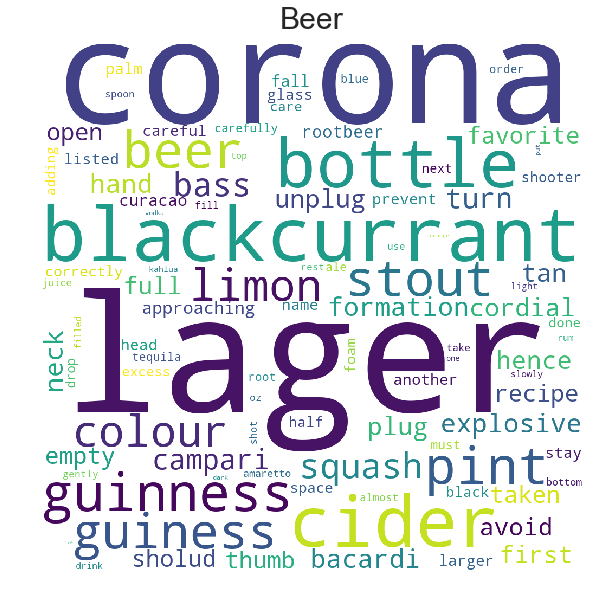

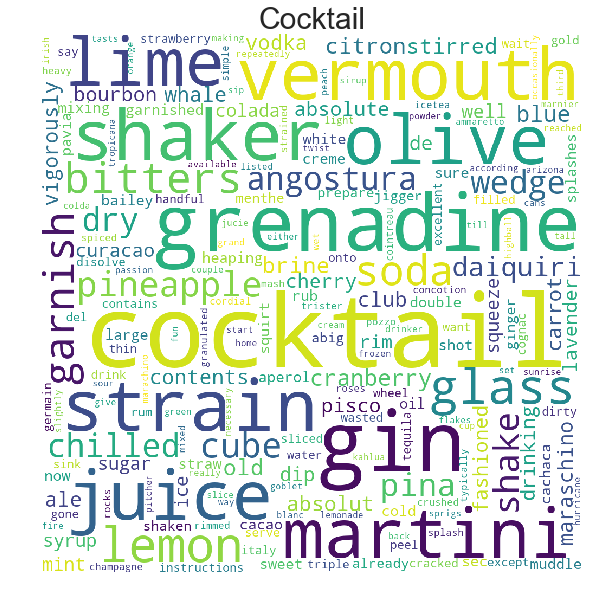

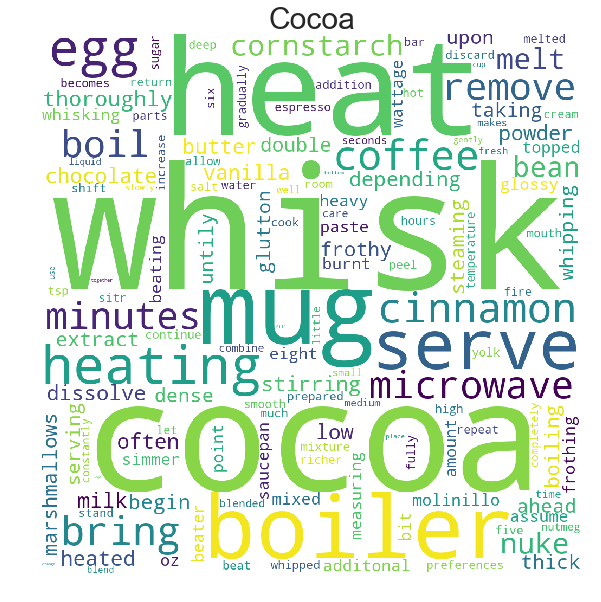

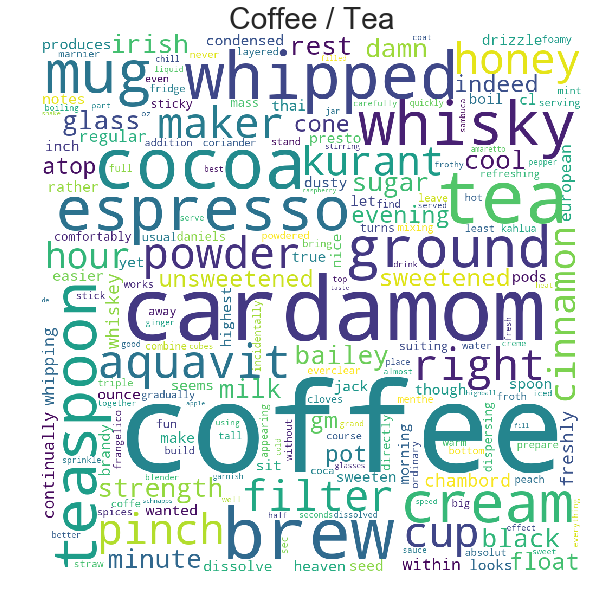

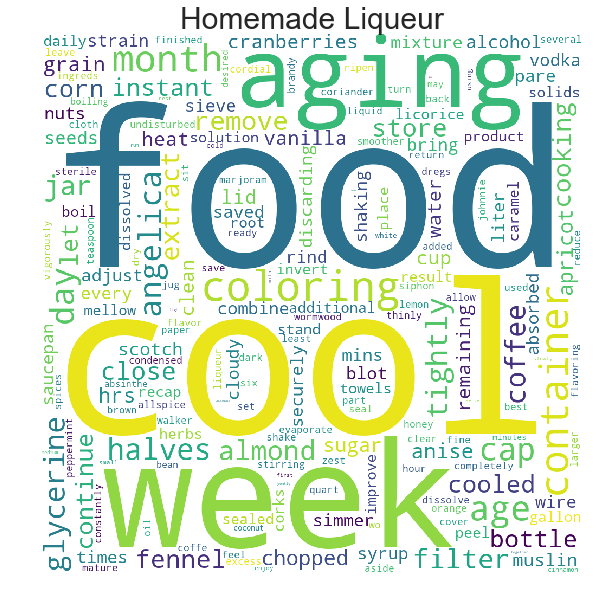

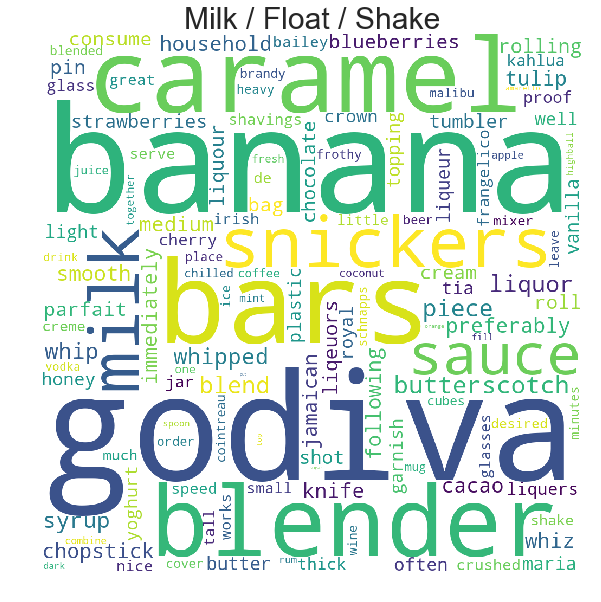

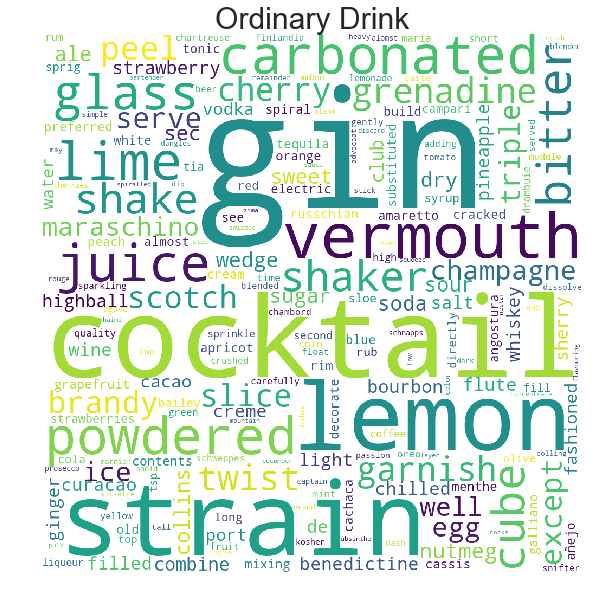

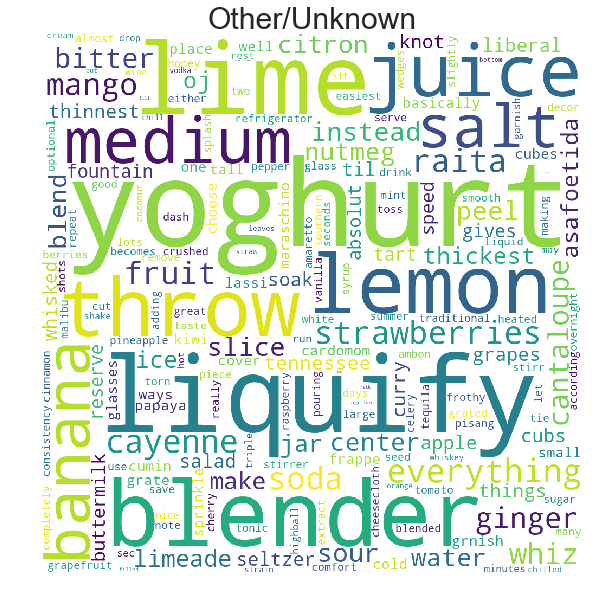

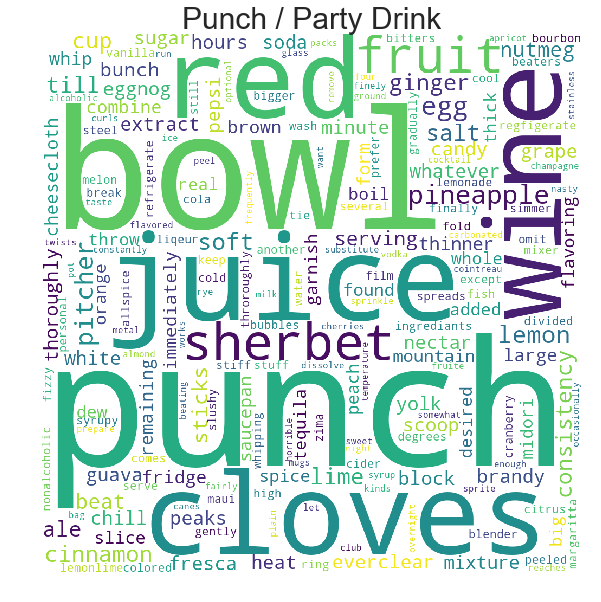

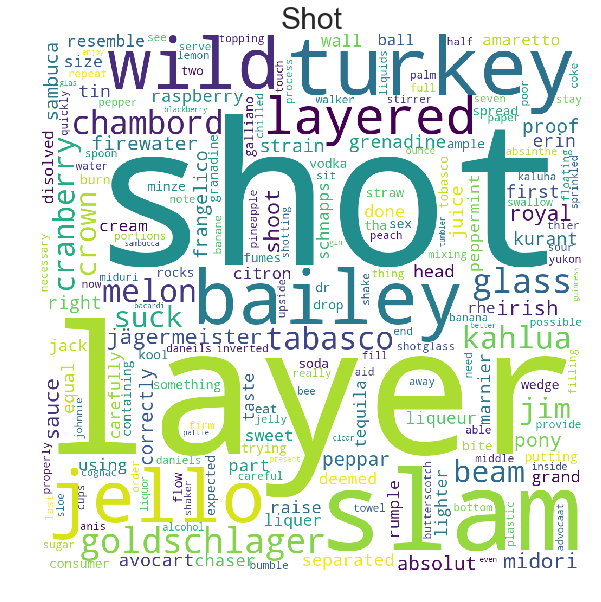

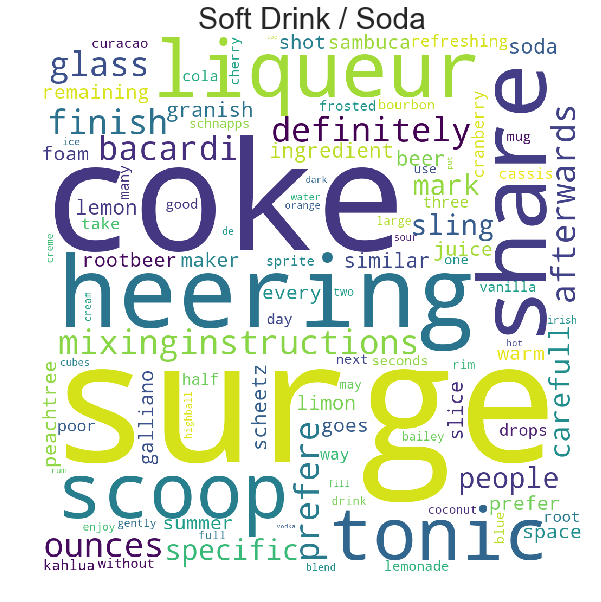

In [47]:
for i in range(len(unique_categories)):

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordclouds[i]) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.title(unique_categories[i], fontsize=30)

    plt.show() 

**Ingredients-Categories:** When looking at the ingredients for each category of drinks, we can for instance see that that milk-based drinks tend to include whipped cream and ice cream along with a liqueur (this might, for example include pina coladas), while the "Cocktails" category tend to veer towards the more bitter tastes, like drinks with vermouth.

# 4) Discussion

In this project, we have worked with a dataset which contains comprehensive information about different drinks including, for instance, their category, ingredients and instructions. After preliminary analysis on the data, we proceeded to construct a network of drinks where edge weights represent the number of shared ingredients within two drinks. After constructing and providing different visualizations on the network, we conducted community detection on the network and compared the resulted communities with existing drink categories and glass-types.

The central results of the community analysis were that, while the formed communities didn't have proper correspondance to the drink categories of glass-types, there were still some clear associations between communities and categories. For instance, most cocoa and coffee -based drinks were associated within a same community. Furthermore, after constructing wordclouds of the ingredients of each community, we found that while the correspondance to the pre-existing category labels was rather weak, the communities were still quite succesfully represented by their unique, distinguishable type-defining ingredient sets. For instance, one community consisted of drinks that had tequila, lemon/lime and tabasco among their most frequent ingredients while another community was characterized by dry and bitter tastes combined with gin and vermouth.

# 5) Contributions

* **Network:** Alex
* **Community Detection:** Alex
* **WordClouds:** Holger
* **Website:** Fotis
* **Writing, merging and formatting:** Everyone